In [1]:
import pandas as pd
import numpy as np
import os
import datetime
import ipywidgets as widgets
from ipywidgets import interact
from IPython.display import display
import matplotlib.pyplot as plt
from scipy import stats
from google.cloud import bigquery
from google.oauth2 import service_account
import seaborn as sns
sns.set(style="whitegrid")
import warnings
warnings.filterwarnings('ignore')
import matplotlib
matplotlib.style.use('ggplot')
import json
from matplotlib.lines import Line2D

In [2]:
def getdata():
    os.chdir(r"C:\Users\Akshay Gupta\Documents\Projects\Homescape\OnSet\Data")
    old_data=pd.read_pickle("Tuya_Data.pkl")
    old_data['event_time_utc']=pd.to_datetime(old_data['event_time_utc'])
    last_timestamp=old_data.sort_values('event_time_utc')['event_time_utc'].iloc[-1]

    os.chdir(r'C:\Users\Akshay Gupta\Documents\Projects\Homescape\Vizualisations\Config')
    credentials = service_account.Credentials.from_service_account_file('bigqueryauth.json')
    project_id = 'solar-222307'
    client = bigquery.Client(credentials= credentials,project=project_id)

    query_job=client.query('select * from loggers.tuya where event_time_utc>"{}"'.format(last_timestamp))
    # query_job=client.query('select * from loggers.tuya')
    tuya_data = query_job.result().to_dataframe() 

    os.chdir(r"C:\Users\Akshay Gupta\Documents\Projects\Homescape\OnSet\Data")
    if len(tuya_data)>0:
        tuya_data['value']=tuya_data['value'].replace('true','1').replace('false','0')
        tuya_data['value']=tuya_data['value'].astype(float)
        tuya_data['event_time_utc']=pd.to_datetime(tuya_data['event_time_utc'])
        tuya_data=tuya_data.drop_duplicates(subset=['device_id','event_timestamp','code','value'])


        pivot_data=tuya_data.pivot_table(index=['property_id','device_id','event_time_utc'], columns='code', values='value')
        pivot_data=pivot_data.reset_index()
        pivot_data['Date']=[i.date() for i in pivot_data['event_time_utc']]

        for i,j in pivot_data[['device_id','property_id']].drop_duplicates().itertuples(index=False):
            pivot_data.loc[(pivot_data.device_id==i) & (pivot_data.property_id==j), 'cur_voltage']=pivot_data.loc[(pivot_data.device_id==i) & (pivot_data.property_id==j), 'cur_voltage'].fillna(method='ffill')
            pivot_data.loc[(pivot_data.device_id==i) & (pivot_data.property_id==j), 'cur_power']=pivot_data.loc[(pivot_data.device_id==i) & (pivot_data.property_id==j), 'cur_power'].fillna(method='ffill')
            pivot_data.loc[(pivot_data.device_id==i) & (pivot_data.property_id==j), 'cur_current']=pivot_data.loc[(pivot_data.device_id==i) & (pivot_data.property_id==j), 'cur_current'].fillna(method='ffill')


        pivot_data['Month'] = [i.month for i in pivot_data['event_time_utc']]
        pivot_data['Week'] = [i.week for i in pivot_data['event_time_utc']]
        pivot_data['Year'] = [i.year for i in pivot_data['event_time_utc']]

        pivot_data=pivot_data.append(old_data)
        pivot_data.to_pickle("Tuya_Data.pkl")

    os.chdir(r"C:\Users\Akshay Gupta\Documents\Projects\Homescape\OnSet\Data")
    pivot_data=pd.read_pickle("Tuya_Data.pkl")
    pivot_data['event_time_utc']=pd.to_datetime(pivot_data['event_time_utc']) +datetime.timedelta(hours=5.5)

    onset_data=pd.read_pickle('onset_data.pkl')
    onset_data['logged_time_local']=pd.to_datetime(onset_data['logged_time_local'])
    last_timestamp=onset_data.sort_values('logged_time_local')['logged_time_local'].iloc[-1]

    query_job=client.query('select * from loggers.onset where logged_time_local>"{}"'.format(last_timestamp))
    results = query_job.result().to_dataframe()
    onset_data=onset_data.append(results)
    onset_data.to_pickle('onset_data.pkl')
    onset_data['logged_time_local']=pd.to_datetime(onset_data['logged_time_local'])
    pivot_data=pivot_data.reset_index()
    onset_data=onset_data.reset_index()
    return pivot_data,onset_data

def getmetadata(pivot_data,device_map):
    device_map1=device_map[['tuya_id','name']].set_index('tuya_id').to_dict()['name']
    device_map2=device_map[['tuya_id','mean_power_consumption']].set_index('tuya_id').to_dict()['mean_power_consumption']
    device_map3=device_map[['tuya_id','consumption_category']].set_index('tuya_id').to_dict()['consumption_category']
    device_map4=device_map[['tuya_id','type']].set_index('tuya_id').to_dict()['type']
    pivot_data['name']=pivot_data['device_id'].map(device_map1)
    pivot_data['device_mean_consumption']=pivot_data['device_id'].map(device_map2)
    pivot_data['consumption_category']=pivot_data['device_id'].map(device_map3)
    pivot_data['type']=pivot_data['device_id'].map(device_map4)
    return pivot_data



def getfeatures(stdate,enddate,data, historical_data):
    
    sample_data=data[(data['logged_time_local']>=pd.to_datetime(stdate)) & (data['logged_time_local']<=pd.to_datetime(enddate))].sort_values('logged_time_local')
#     print(sample_data)
    if 'other' in sample_data.columns:
        temp = historical_data
        if len(temp) > 0:
#             temp['logged_time_local'] = [datetime.datetime.utcfromtimestamp(timestamp) + datetime.timedelta(seconds=19800) for timestamp in temp['timestamp']]
            df = temp[['logged_time_local', 'mains_power']]
            df = temp.append(data[['logged_time_local', 'mains_power']])
        else:
            df = sample_data[['logged_time_local', 'mains_power']]
        n = len(temp)
#         print(' other df >>>>>', df)

    else:
        df = pd.DataFrame(columns=sample_data.columns)
        df = df.append(pd.DataFrame(json.loads(historical_data)))
        n=len(df)
        #### Time change in pipeline
        df['logged_time_local'] = [datetime.datetime.utcfromtimestamp(timestamp) for timestamp in df['timestamp']]
        sample_data = sample_data.sort_values('logged_time_local').set_index('logged_time_local').resample('1s').interpolate().reset_index()
        df = df.append(sample_data)
#         print(df)

    mean_step=2
    factor=10
#     sample_data=df
    ### Processing
    df['before_mean']=df['mains_power'].rolling(mean_step).mean()
    df['before_max_10']=df['mains_power'].abs().rolling(mean_step*factor).max()
    df['before_mean_10']=df['mains_power'].abs().rolling(mean_step*factor).mean()
    df['after_mean']=0
    df['after_mean_10']=0
    df['after_max_10']=0
    df['per_change']=0
    df['time_spent']=0

    # Features
    per_change=[]
    after_mean=[]
    after_mean_10=[]
    after_max=[]

    for i in range(mean_step,len(df)-mean_step):
        change=100*(df['before_mean'].iloc[i+mean_step]-df['before_mean'].iloc[i-1])/df['before_mean'].iloc[i+mean_step]
        per_change.append(change)
        after_mean.append(df['before_mean'].iloc[i+mean_step])

    for i in range(mean_step*factor,len(df)-mean_step*factor-3):
        after_mean_10.append(df['before_mean_10'].iloc[i+3+mean_step*factor])
        after_max.append(df['before_max_10'].iloc[i+3+mean_step*factor])

    df['per_change'].iloc[mean_step:-mean_step]=per_change
    df['after_mean'].iloc[mean_step:-mean_step]=after_mean
    df['after_mean_10'].iloc[mean_step*factor:-mean_step*factor-3]=after_mean_10
    df['after_max_10'].iloc[mean_step*factor:-mean_step*factor-3]=after_max
    df['avg_diff']=df['after_mean']-df['before_mean']
    df['avg_diff']=df['after_mean']-df['before_mean']
    
    #event logic
    df['events']=0
    df.loc[(abs(df['avg_diff'])>.015) & (df['mains_power']<.10), 'events']=1
    df.loc[(abs(df['per_change'])>10) & (df['mains_power']>.10), 'events']=1
    df=df
    df['event_type']=0

    #### transition start=1, transition= 2, transition end=3, steady=0
    df.loc[df['events']==True,'event_type']=2
    df.loc[df['events']==False,'event_type']=0
    
    #### map transition states
    df['event_effect']=0
    prev_state=0
    event_mean_before=0
    for i in range(1,len(df)):
        if df['events'].iloc[i]==0:
            if prev_state==1:
                df['event_type'].iloc[i-1]=3
            prev_state=0
        else:
            if prev_state==0:
                df['event_type'].iloc[i]=1
            prev_state=1
    
    
    #### Observable events for on/off activity
    df['observable_event']=0
#     df.loc[df['event_type']==1,'event_effect']=df.loc[df['event_type']==1,'after_mean_10']-df.loc[df['event_type']==1,'before_mean_10']
#     df.loc[df['event_type']==1,'event_effect_peak']=df.loc[df['event_type']==1,'after_max_10']-df.loc[df['event_type']==1,'before_max_10']
    df['event_effect']=0
    for i in range(len(df)):
        if df['event_type'].iloc[i]==1:
            after=0
            j=i+5
            for j in range(i+5,min(i+5+mean_step*factor,len(df)-1)):
                if (df['event_type'].iloc[j] != 1):
                    after=after +   df['mains_power'].iloc[j]
                else:
                    break
            after=after/(j-(i+4))
            before=0
            k=i-3
            for k in range(i-3,max(i-3-mean_step*factor,0),-1):
                if (df['event_type'].iloc[k] != 1):
                    before=before +   df['mains_power'].iloc[k]
                else:
                    break
            before=before/(i-(k+2))
            df['event_effect'].iloc[i]=after-before
    
    
    df.loc[(abs(df['event_effect'])>.010),'observable_event']=1
    df.loc[(df['event_effect']<0) & (df['observable_event']==1),'observable_event']=2
#     print(df)
#     print(df.iloc[n:,:])
    return df.iloc[n:,:]

# def classify_appliance(appliances,power,device_map):
#     if appliances=='all':
#         return device_map['name'].iloc[(device_map['mean_power_consumption']-power).abs().argsort()[:1]].values[0]
#     else:
#         if len(device_map.loc[device_map['name'].isin(appliances)])==0:
#             return 0
#         else:
#             return device_map.loc[device_map['name'].isin(appliances),'name'].iloc[(device_map.loc[device_map['name'].isin(appliances), 'mean_power_consumption']-abs(power)).abs().argsort()[:1]].values[0]

def classify_appliance(appliances,power,device_map,category=True):
    if appliances=='all':
        return device_map['name'].iloc[(device_map['mean_power_consumption']-power).abs().argsort()[:1]].values[0]
    else:
        if len(device_map.loc[(device_map['name'].isin(appliances)) & (device_map['consumption_category']==category)])==0:
            return 0
        else:
            return device_map.loc[(device_map['name'].isin(appliances)) & (device_map['consumption_category']==category),'name'].iloc[(device_map.loc[(device_map['name'].isin(appliances)) & (device_map['consumption_category']==category), 'mean_power_consumption']-abs(power)).abs().argsort()[:1]].values[0]
    

def estimated_usage(std,endd,appliance,device_map):
    return device_map.loc[device_map['name']==appliance, 'mean_power_consumption']*(endd-std).seconds/3600

def getoutput(stdate,enddate,temp_data,device_map):

    event_df=pd.DataFrame(columns=['start_on_local','end_on_local','avg_mains_power','equipment_name','status','energy_consumption','event_on_local','event_off_local'])
    ind=1
    prev_avg_mains_power=.088
    active_names={}
    active_names['other']=stdate
#     main_temp=pd.DataFrame()
#     appliance_list=[]
#     event_df=pd.DataFrame(columns=['start_on_local','end_on_local','avg_mains_power','name','status','energy_consumption','event_on_local','event_off_local'])
    main_temp=pd.DataFrame()
    appliance_list=[]
    for start,end in zip(pd.date_range(stdate,enddate, freq='5min')[:-1],pd.date_range(stdate,enddate, freq='5min')[1:]):
        event_df_temp=pd.DataFrame(columns=['start_on_local','end_on_local','avg_mains_power','name','status','energy_consumption','event_on_local','event_off_local'])
        temp=temp_data.set_index('logged_time_local')
        temp=temp[(temp.index<=end) & (temp.index>=start)]
        event_df_temp.loc[ind]=[start,end,None,'all','NA',temp['mains_power'].sum()/3600,None,None]
        temp['active_appliances']=None
        for name in active_names.keys():
            ind=ind+1
            event_df_temp.loc[ind,'name']=name
            event_df_temp.loc[event_df_temp['name']==name,'event_on_local']=str(start)
            event_df_temp.loc[event_df_temp['name']==name,'status']='active'
        
        event_df_temp.loc[event_df_temp['name']=='other']=[start,end,prev_avg_mains_power,'other','NA',0,str(start),str(end)]
        for i in range(len(temp)):
            temp['active_appliances'].iloc[i]=list(active_names)
            if temp['observable_event'].iloc[i]==1:

 

                name=classify_appliance('all',abs(temp['event_effect'].iloc[i]),device_map)
                if name in event_df_temp['name'].unique():
                    if name in active_names.keys():
                        continue
                    else:
                        active_names[name]=str(temp.index[i])
                        event_df_temp.loc[event_df_temp['name']==name,'status']='active'
                        event_df_temp.loc[event_df_temp['name']==name,'event_on_local']=str(event_df_temp.loc[event_df_temp['name']==name,'event_on_local'].values[0])+' '+str(temp.index[i])
                else:
                    ind=ind+1
                    event_df_temp.loc[ind,'event_on_local']=str(temp.index[i])
                    event_df_temp.loc[ind,'name']=name
                    event_df_temp.loc[ind,'status']='active'
                    active_names[name]=str(temp.index[i])

 

            elif temp['observable_event'].iloc[i]==2:
                category=category= ['high' if v > 1 else 'low' if v <= .01 else 'medium' for v in [abs(temp['event_effect'].iloc[i])]][0]
                name=classify_appliance(active_names.keys(),abs(temp['event_effect'].iloc[i]),device_map,category)
                if name==0:
                    continue
                if  len(event_df_temp.loc[event_df_temp['name']==name,'event_off_local'].dropna())==0:
                    event_df_temp.loc[event_df_temp['name']==name,'event_off_local']=str(temp.index[i])
                else:
                    event_df_temp.loc[event_df_temp['name']==name,'event_off_local']=str(event_df_temp.loc[event_df_temp['name']==name,'event_off_local'].values[0])+','+str(temp.index[i])
                event_df_temp.loc[event_df_temp['name']==name,'status']='off'
                del active_names[name]
            else:
                continue

 

        for name in active_names.keys():
            if name=='other':
                continue
            if len(event_df_temp.loc[event_df_temp['name']==name,'event_off_local'].dropna())==0:
                event_df_temp.loc[event_df_temp['name']==name,'event_off_local']=str(temp.index[i])
            else:
                event_df_temp.loc[event_df_temp['name']==name,'event_off_local']=str(event_df_temp.loc[event_df_temp['name']==name,'event_off_local'].values[0])+','+str(temp.index[i])
        event_df_temp['start_on_local']=start
        event_df_temp['end_on_local']=end
        
        for iterator in range(3):
            if iterator==0:
                per_second_energy,energy_dict=energy_estimation(temp,prev_avg_mains_power)
            else:
                per_second_energy,energy_dict=energy_estimation(sample_df,prev_avg_mains_power)
            per_second_energy['mains_power']=per_second_energy['other']
            
            for equip in list(energy_dict):
                if equip=='other':
                    continue
                else:
                    event_df_temp.loc[event_df_temp['name']==equip,'energy_consumption']=event_df_temp.loc[event_df_temp['name']==equip,'energy_consumption'].fillna(0)+energy_dict[equip]/3600
#             print(per_second_energy)
            sample_df=getfeatures(stdate,enddate,per_second_energy,temp[-60:].reset_index()) 
#             print(sample_df)
            sample_df=sample_df.set_index('logged_time_local')
            sample_df['active_appliances']=temp['active_appliances']
        
        event_df_temp.loc[event_df_temp['name']=='other','energy_consumption']=energy_dict['other']/3600
        prev_avg_mains_power=energy_dict['other']/3600
        event_df=event_df.append(event_df_temp)
        main_temp=main_temp.append(temp)

 

    device_map1=device_map[['name','tuya_id']].set_index('name').to_dict()['tuya_id']
    device_map2=device_map[['name','room']].set_index('name').to_dict()['room']
    device_map3=device_map[['name','consumption_category']].set_index('name').to_dict()['consumption_category']
    device_map4=device_map[['name','phase']].set_index('name').to_dict()['phase']
    device_map5=device_map[['name','type']].set_index('name').to_dict()['type']
    event_df['tuya_id']=event_df['name'].map(device_map1)
    event_df['room']=event_df['name'].map(device_map2)
    event_df['consumption_category']=event_df['name'].map(device_map3)
    event_df['phase']=event_df['name'].map(device_map4)
    event_df['type']=event_df['name'].map(device_map5)
    event_df.loc[event_df['name']=='other','consumption_category']=event_df.loc[event_df['name']!='all','consumption_category'].fillna('other')
    event_df.loc[event_df['name']=='other','type']='other'    
    return main_temp,event_df

def energy_estimation(temp,other_original):
#     temp=temp[['mains_power','active_appliances']]

# def energy_estimation(temp)
    energy_dict={l:0 for l in list({x for l in list(temp.active_appliances) for x in l})}
    prev_energy_dict={}
#     other_original=0.088
    energy_dict={l:0 for l in list({x for l in list(temp.active_appliances) for x in l})}
    per_second_energy=[]
    ind=0
    df=pd.DataFrame(columns=energy_dict.keys())

    for i in range(len(temp)):
        prev_energy_dict['other']=other_original

        ### Distribution of Energy between Appliances
        if len(prev_energy_dict)==len(temp.active_appliances.iloc[i]):
            prev_energy_dict[list(prev_energy_dict.keys())[-1]]=temp.mains_power.iloc[i]-sum(list(prev_energy_dict.values())[0:-1])

        ### New Appliance is Active
        elif len(prev_energy_dict)<len(temp.active_appliances.iloc[i]):
            new_appliance=list((set(temp.active_appliances.iloc[i]) - set(prev_energy_dict)))[0]
            prev_energy_dict[new_appliance]=temp.mains_power.iloc[i]-sum(prev_energy_dict.values())

        ### One of the Appliances Deactives
        else:
            removed_appliance=list((set(prev_energy_dict)- set(temp.active_appliances.iloc[i])))[0]
            del prev_energy_dict[removed_appliance]
            prev_energy_dict[list(prev_energy_dict.keys())[-1]]=temp.mains_power.iloc[i]-sum(list(prev_energy_dict.values())[0:-1])

        ### Case When Calculated Equipment Usage > 1.5*Mean Consumption 
        excess=0
        negative_energy=[]
        for equipment in prev_energy_dict.keys():
            if equipment=='other':
                continue
            else:
                equipment_energy=prev_energy_dict[equipment]
                if equipment_energy>0:
                    prev_energy_dict[equipment]=min(equipment_energy,device_map.loc[device_map['name']==equipment,'mean_power_consumption'].values[0]*1.5)
                    excess=excess+equipment_energy-min(equipment_energy,device_map.loc[device_map['name']==equipment,'mean_power_consumption'].values[0]*1.5)
                else:
                    negative_energy.append(equipment)

        ### Remove Appliance if Calculated energy of appliance is negative
        for negative_equipment in negative_energy:
            del prev_energy_dict[negative_equipment]

        ### Add Excessive Energy to other
        other_original=prev_energy_dict['other']
        prev_energy_dict['other']=prev_energy_dict['other']+excess

        ### Check if Sum of all Appliance Energy> Original, if yes remove from original and subsequent appliances
        for appliance_excess in list(prev_energy_dict):
            if (sum(prev_energy_dict.values())-temp.mains_power.iloc[i])<=.015:
                break
            else:
                if appliance_excess=='other':
                    prev_energy_dict[appliance_excess]=max(.015,temp.mains_power.iloc[i]-sum(prev_energy_dict.values()))
                else:
                    prev_energy_dict[appliance_excess]=max(0,temp.mains_power.iloc[i]-sum(prev_energy_dict.values()))


    #     print(str(temp.index[i])+str(prev_energy_dict)+str(excess))
        for j in prev_energy_dict.keys():
            energy_dict[j]=energy_dict[j]+prev_energy_dict[j]
        per_second_energy.append(str(prev_energy_dict))
    per_second_energy=pd.DataFrame([eval(i) for i in per_second_energy])
    per_second_energy['logged_time_local']=temp.index
        
    return per_second_energy,energy_dict

In [3]:
pivot_data,onset_data=getdata()
onset_data=onset_data.iloc[:,1:]

In [12]:
historical_json=onset_data.iloc[:60,:].to_json()
os.chdir(r"C:\Users\Akshay Gupta\Documents\Projects\Homescape\OnSet\Data")
device_map=pd.read_excel('Tuya devices power.xlsx').fillna('none')
stdate='2021-01-04 00:30:00'
enddate='2021-01-04 23:30:00'
pivot_data=getmetadata(pivot_data,device_map)
sample_data=getfeatures(stdate,enddate,onset_data,historical_json)

In [13]:
temp,output=getoutput(stdate,enddate,sample_data,device_map)

In [14]:
# os.chdir(r'C:\Users\Akshay Gupta\Documents\Projects\Homescape\Vizualisations\Config')
# credentials = service_account.Credentials.from_service_account_file('bigqueryauth.json')
# project_id = 'solar-222307'
# client = bigquery.Client(credentials= credentials,project=project_id)
# start='2021-02-21'
# end='2021-02-22'
# output=client.query('select * from dev_loggers.disaggregation_dashboard where start_on_local>="{}" and start_on_local<"{}"'.format(start,end)).result().to_dataframe()
# os.chdir(r'C:\Users\Akshay Gupta\Documents\Projects\Homescape\Vizualisations\Data')
# output

In [15]:
# for i in range(3):
#     if i==0:
#         per_second_energy,energy_dict=energy_estimation(temp,0.088)
#     else:
#         per_second_energy,energy_dict=energy_estimation(sample_df,0.088)
#     per_second_energy['mains_power']=per_second_energy['other']
#     for i in list(energy_dict):
#         if i=='other':
#             continue
#         else:
#             output.loc[output['equipment_name']==i,'energy_consumption']=output.loc[output['equipment_name']==i,'energy_consumption']+energy_dict[i]
#     sample_df=getfeatures(stdate,enddate,per_second_energy)
#     sample_df=sample_df.set_index('logged_time_local')
#     sample_df['active_appliances']=temp['active_appliances']


In [16]:
# stime=pd.to_datetime('2021-01-04 06:45:40')
# etime=pd.to_datetime('2021-01-04 09:47:10')
# temp_data5=sample_data[(sample_data.logged_time_local>stime) & (sample_data.logged_time_local<etime)].set_index('logged_time_local')
# temp_data=sample_df2[(sample_df2.logged_time_local>stime) & (sample_df2.logged_time_local<etime)].set_index('logged_time_local')
# temp_data4=sample_df[(sample_df.logged_time_local>stime) & (sample_df.logged_time_local<etime)].set_index('logged_time_local')

# temp_data2=temp_data[temp_data['observable_event'].isin([1])]
# temp_data3=temp_data[temp_data['observable_event'].isin([2])]
# fig,ax=plt.subplots()
# # ax2=ax.twinx()
# matplotlib.style.use('default')
# fig.set_size_inches(15,5)
# ax.scatter(temp_data2.index,temp_data2.mains_power, color='green', s=15)
# ax.scatter(temp_data3.index,temp_data3.mains_power,color='red', s=15)
# ax.plot(temp_data.index,temp_data.mains_power,color='black', lw=.5)
# # ax.plot(temp_data4.index,temp_data4.mains_power,color='blue', lw=.5)
# ax.plot(temp_data5.index,temp_data5.mains_power,color='red', lw=.5)
# # ax.set_ylim(0,.2)
# ax.legend

In [17]:
# stime='2021-01-04 08:10:00'
# etime='2021-01-04 08:15:02'
# onset_data.logged_time_local=pd.to_datetime(onset_data.logged_time_local)
# df=onset_data[(onset_data.logged_time_local>stime) & (onset_data.logged_time_local<etime)].set_index('logged_time_local')

# matplotlib.style.use('default')
# fig,ax=plt.subplots()
# df.mains_power.plot(ax=ax)
# # colors= [ 'red','blue','blue','grey','yellow','black']
# # ax.set_prop_cycle(cy)
# ax.grid('')
# fig.set_size_inches(15,5)

In [18]:
output.to_csv('Final_Output_v3.csv')

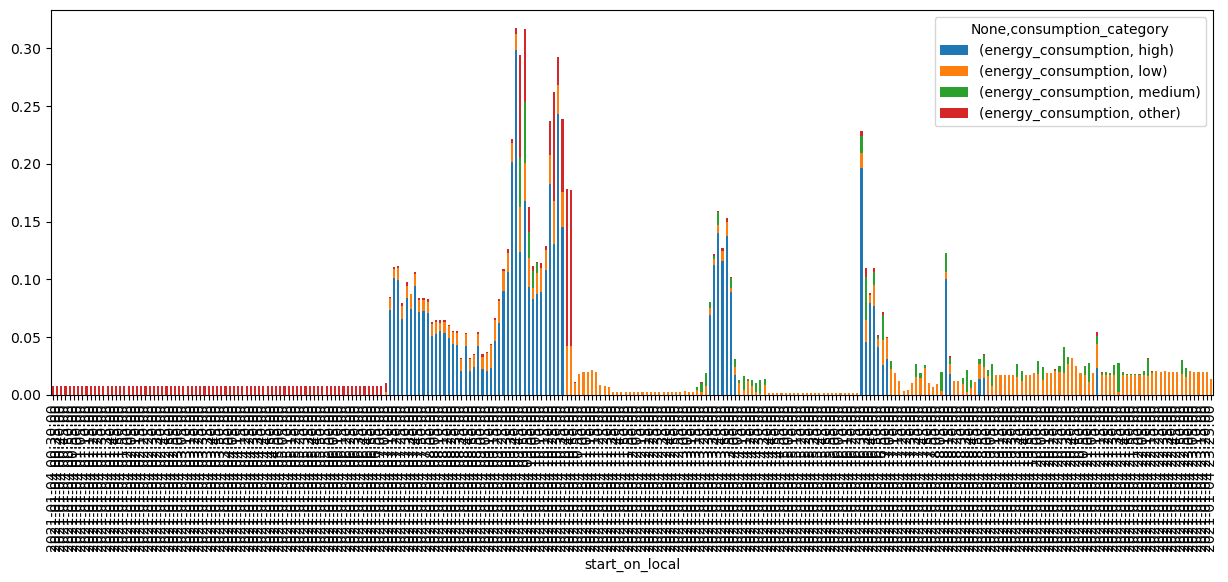

In [19]:
from cycler import cycler
stime='2021-01-04 00:00:00'
etime='2021-01-04 23:50:00'
output.start_on_local=pd.to_datetime(output.start_on_local)
df=output[(output.start_on_local>stime) & (output.start_on_local<etime)]
df['consumption_category']=df['consumption_category'].fillna('actual')
df1=df[df['consumption_category']!='actual']
df2=df[df['consumption_category']=='actual']
df1_pivot=df1.pivot_table(index=['start_on_local','consumption_category'], values='energy_consumption', aggfunc=np.sum)
df_total_actual=df2.pivot_table(index=['start_on_local','consumption_category'], values='energy_consumption', aggfunc=np.sum)
df_total_estimated=df1.pivot_table(index=['start_on_local'], values='energy_consumption', aggfunc=np.sum)
matplotlib.style.use('default')
fig,ax=plt.subplots()
# colors= [ 'red','blue','blue','grey','yellow','black']
# ax.set_prop_cycle(cy)
ax.grid('')
fig.set_size_inches(15,5)
df1_pivot.unstack().plot(kind='bar',ax=ax,stacked=True)

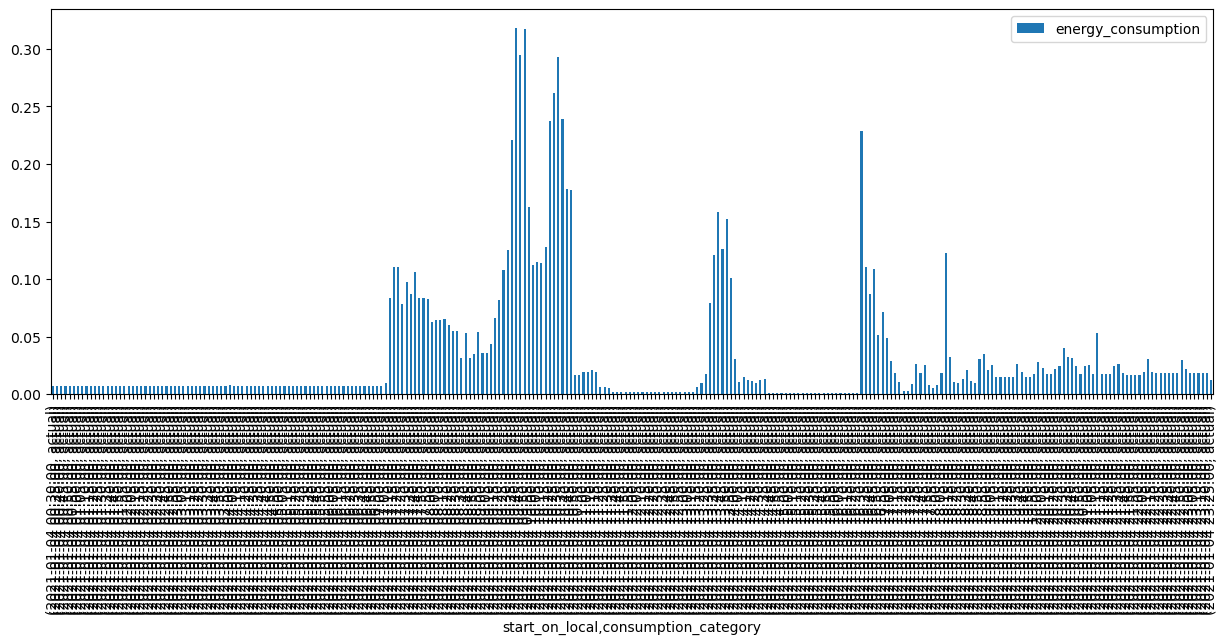

In [20]:
fig,ax=plt.subplots()
ax.grid('')
fig.set_size_inches(15,5)
(df_total_actual).plot(kind='bar',ax=ax,stacked=True)

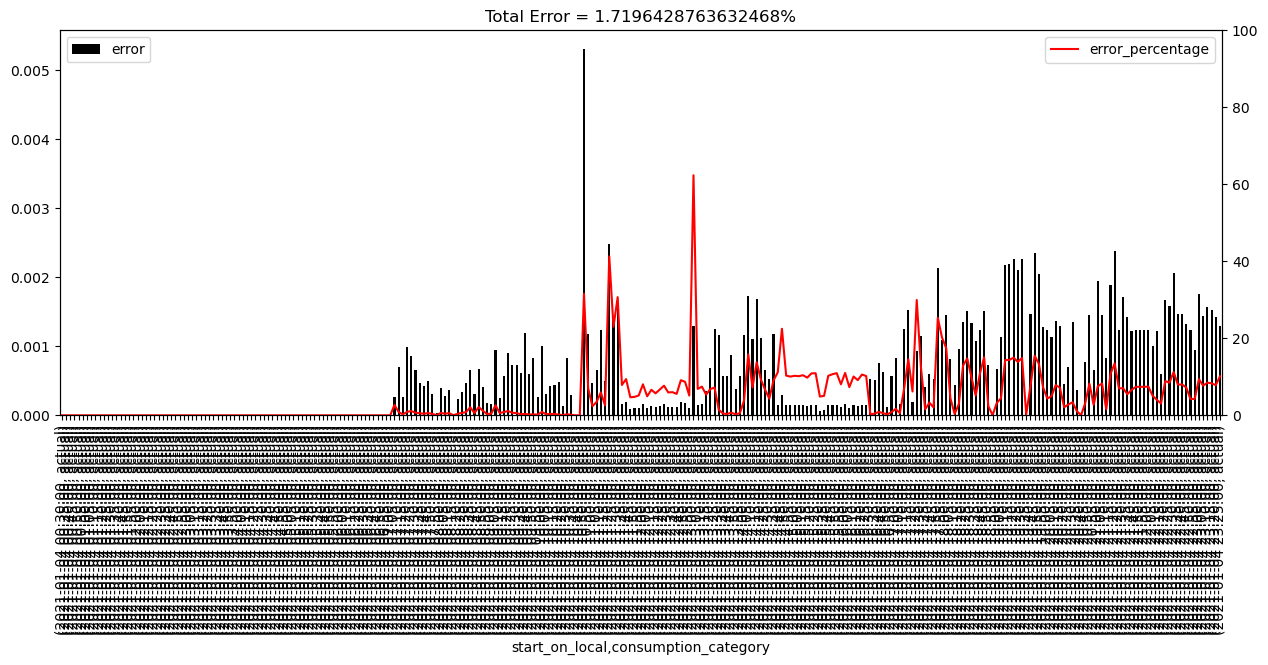

In [21]:
fig,ax=plt.subplots()
ax2=ax.twinx()
ax.grid('')
fig.set_size_inches(15,5)
abs(df_total_actual-df_total_estimated).plot(kind='bar',ax=ax,stacked=True,color='black')
(100*abs(df_total_actual-df_total_estimated)/df_total_actual).plot(ax=ax2,stacked=True,title='Total Error = '+str((100*abs(df_total_actual-df_total_estimated).sum()/df_total_actual.sum()).values[0])+'%', color='red')
# ax.set_ylim(0,0.12)
ax2.set_ylim(0,100)
ax.legend(loc=2, labels=['error'])
ax2.legend(loc=1,labels=['error_percentage'])
# ax.title()

In [22]:
(100*abs(df_total_actual-df_total_estimated)/df_total_actual).mean()[0]

4.716364595128421

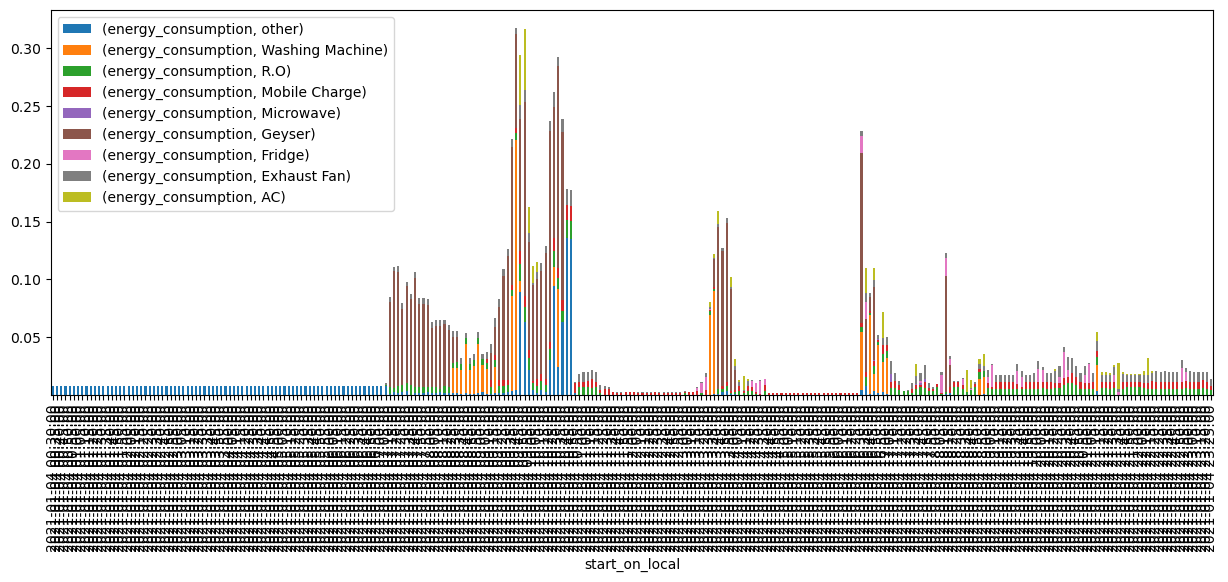

In [23]:
# stime=pd.to_datetime('2021-01-04 09:00:00')
# stime='2021-01-04 00:30:00'
# etime='2021-01-04 23:30:00'
df=output[(output.start_on_local>stime) & (output.start_on_local<etime)]
df['consumption_category']=df['consumption_category'].fillna('actual')
df1=df[df['name']!='all']
df2=df[df['name']=='all']
df1_pivot=df1.pivot_table(index=['start_on_local','type'], values='energy_consumption', aggfunc=np.sum)
df_total_actual=df2.pivot_table(index=['start_on_local','type'], values='energy_consumption', aggfunc=np.sum)
df_total_estimated=df1.pivot_table(index=['start_on_local'], values='energy_consumption', aggfunc=np.sum)
# matplotlib.style.use('seaborn-dark')
fig,ax=plt.subplots()
ax.grid('')
fig.set_size_inches(15,5)
df1_pivot.unstack()[df1_pivot.unstack().columns[::-1]].plot(kind='bar',ax=ax,stacked=True)
ax.legend(loc=2)

# stime=pd.to_datetime('2021-01-04 09:00:00')
# stime= start
# etime=end
# df=output[(output.start_on_local>stime) & (output.start_on_local<etime)]
# df['consumption_category']=df['consumption_category'].fillna('actual')
# df1=df[df['equipment_name']!='all']
# df2=df[df['equipment_name']=='all']
# df1_pivot=df1.pivot_table(index=['start_on_local','equipment_type'], values='energy_consumption', aggfunc=np.sum)
# df_total_actual=df2.pivot_table(index=['start_on_local','equipment_type'], values='energy_consumption', aggfunc=np.sum)
# df_total_estimated=df1.pivot_table(index=['start_on_local'], values='energy_consumption', aggfunc=np.sum)
# # matplotlib.style.use('seaborn-dark')
# fig,ax=plt.subplots()
# ax.grid('')
# fig.set_size_inches(15,5)
# df1_pivot.unstack()[df1_pivot.unstack().columns[::-1]].plot(kind='bar',ax=ax,stacked=True)
# ax.legend(loc=2)

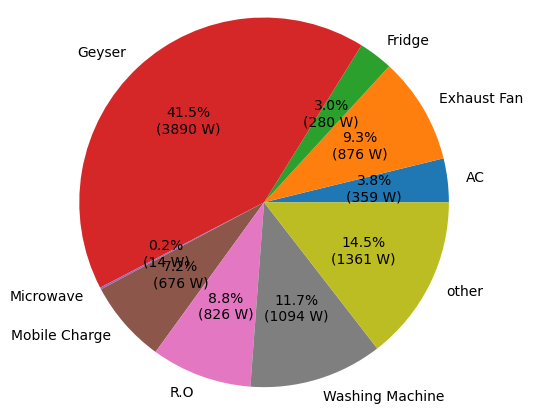

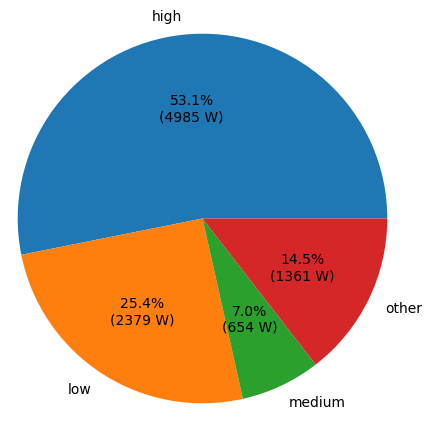

In [24]:
def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:d} W)".format(pct, absolute)
# stime='2021-01-04 00:30:00'
# etime='2021-01-04 23:30:00'
df=output[(output.start_on_local>=stime) & (output.start_on_local<=etime)]
pivot1=df.pivot_table(index='type', values='energy_consumption', aggfunc=np.sum)
pivot2=df.pivot_table(index='consumption_category', values='energy_consumption', aggfunc=np.sum)
fig,ax =plt.subplots()
fig.set_size_inches(15,5)
# ax.plot(pivot1[pivot1.index!='all'], labels=pivot1[pivot1.index!='all'].index)
ax.pie(pivot1[pivot1.index!='all'], labels=pivot1[pivot1.index!='all'].index, autopct=lambda pct: func(pct, 1000*pivot1[pivot1.index!='all']),radius=1.2)
ax.legend().remove()

fig,ax =plt.subplots()
fig.set_size_inches(15,5)
ax.pie(pivot2[pivot2.index!='all'], labels=pivot2[pivot2.index!='all'].index,autopct=lambda pct: func(pct, 1000*pivot2[pivot2.index!='all']),radius=1.2)
ax.legend().remove()

# def func(pct, allvals):
#     absolute = int(pct/100.*np.sum(allvals))
#     return "{:.1f}%\n({:d} W)".format(pct, absolute)
# stime=start
# etime=end
# df=output[(output.start_on_local>=stime) & (output.start_on_local<=etime)]
# pivot1=df.pivot_table(index='equipment_type', values='energy_consumption', aggfunc=np.sum)
# pivot2=df.pivot_table(index='consumption_category', values='energy_consumption', aggfunc=np.sum)
# fig,ax =plt.subplots()
# fig.set_size_inches(15,5)
# # ax.plot(pivot1[pivot1.index!='all'], labels=pivot1[pivot1.index!='all'].index)
# ax.pie(pivot1[pivot1.index!='all'], labels=pivot1[pivot1.index!='all'].index, autopct=lambda pct: func(pct, 1000*pivot1[pivot1.index!='all']),radius=1.2)
# ax.legend().remove()

# fig,ax =plt.subplots()
# fig.set_size_inches(15,5)
# ax.pie(pivot2[pivot2.index!='all'], labels=pivot2[pivot2.index!='all'].index,autopct=lambda pct: func(pct, 1000*pivot2[pivot2.index!='all']),radius=1.2)
# ax.legend().remove()


In [269]:
# stime=pd.to_datetime('2021-01-04 07:15:10')
# etime=pd.to_datetime('2021-01-04 11:30:59')
# temp_data=sample_df[(sample_df.index>stime) & (sample_df.index<etime)]
# temp_data4=temp[(temp.index>stime) & (temp.index<etime)]

# temp_data2=temp_data[temp_data['observable_event'].isin([1])]
# temp_data3=temp_data[temp_data['observable_event'].isin([2])]
# fig,ax=plt.subplots()
# # ax2=ax.twinx()
# matplotlib.style.use('default')
# fig.set_size_inches(15,5)
# ax.scatter(temp_data2.index,temp_data2.mains_power, color='green', s=15)
# ax.scatter(temp_data3.index,temp_data3.mains_power,color='red', s=15)
# ax.plot(temp_data.index,temp_data.mains_power,color='black', lw=.5)
# # ax.plot(temp_data4.index,temp_data4.mains_power,color='blue', lw=.5)
# # ax.set_ylim(0,.2)
# ax.legend

In [ ]:
def getfeatures(stdate,enddate,onset_data):
    
    sample_data=onset_data[(onset_data['logged_time_local']>=pd.to_datetime(stdate)) & (onset_data['logged_time_local']<=pd.to_datetime(enddate))][['mains_power','logged_time_local']].sort_values('logged_time_local')

    mean_step=2
    factor=10

    ### Processing
    sample_data['before_mean']=sample_data['mains_power'].rolling(mean_step).mean()
#     sample_data['before_max_10']=sample_data['mains_power'].abs().rolling(mean_step*factor).max()
#     sample_data['before_mean_10']=sample_data['mains_power'].abs().rolling(mean_step*factor).mean()
    sample_data['after_mean']=0
#     sample_data['after_mean_10']=0
#     sample_data['after_max_10']=0
    sample_data['per_change']=0
    sample_data['time_spent']=0

    # Features
    per_change=[]
    after_mean=[]
    after_mean_10=[]
    after_max=[]

    for i in range(mean_step,len(sample_data)-mean_step):
        change=100*(sample_data['before_mean'].iloc[i+mean_step]-sample_data['before_mean'].iloc[i-1])/sample_data['before_mean'].iloc[i+mean_step]
        per_change.append(change)
        after_mean.append(sample_data['before_mean'].iloc[i+mean_step])

#     for i in range(mean_step*factor,len(sample_data)-mean_step*factor-3):
#         after_mean_10.append(sample_data['before_mean_10'].iloc[i+3+mean_step*factor])
#         after_max.append(sample_data['before_max_10'].iloc[i+3+mean_step*factor])

    sample_data['per_change'].iloc[mean_step:-mean_step]=per_change
    sample_data['after_mean'].iloc[mean_step:-mean_step]=after_mean
#     sample_data['after_mean_10'].iloc[mean_step*factor:-mean_step*factor-3]=after_mean_10
#     sample_data['after_max_10'].iloc[mean_step*factor:-mean_step*factor-3]=after_max
    sample_data['avg_diff']=sample_data['after_mean']-sample_data['before_mean']
    sample_data['avg_diff']=sample_data['after_mean']-sample_data['before_mean']
    
    #event logic
    sample_data['events']=0
    sample_data.loc[(abs(sample_data['avg_diff'])>.015) & (sample_data['mains_power']<.10), 'events']=1
    sample_data.loc[(abs(sample_data['per_change'])>10) & (sample_data['mains_power']>.10), 'events']=1
#     sample_data=sample_data
    sample_data['event_type']=0

    #### transition start=1, transition= 2, transition end=3, steady=0
    sample_data.loc[sample_data['events']==True,'event_type']=2
    sample_data.loc[sample_data['events']==False,'event_type']=0
    
    #### map transition states
    sample_data['event_effect']=0
    prev_state=0
    event_mean_before=0
    for i in range(1,len(sample_data)):
        if sample_data['events'].iloc[i]==0:
            if prev_state==1:
                sample_data['event_type'].iloc[i-1]=3
            prev_state=0
        else:
            if prev_state==0:
                sample_data['event_type'].iloc[i]=1
            prev_state=1
    
    
    #### Observable events for on/off activity
    sample_data['observable_event']=0
#     sample_data.loc[sample_data['event_type']==1,'event_effect']=sample_data.loc[sample_data['event_type']==1,'after_mean_10']-sample_data.loc[sample_data['event_type']==1,'before_mean_10']
#     sample_data.loc[sample_data['event_type']==1,'event_effect_peak']=sample_data.loc[sample_data['event_type']==1,'after_max_10']-sample_data.loc[sample_data['event_type']==1,'before_max_10']
    sample_data['event_effect']=0
    for i in range(len(sample_data)):
        if sample_data['event_type'].iloc[i]==1:
            after=0
            j=i+5
            for j in range(i+5,min(i+5+mean_step*factor,len(sample_data)-1)):
                if (sample_data['event_type'].iloc[j] != 1):
                    after=after +   sample_data['mains_power'].iloc[j]
                else:
                    break
            after=after/(j-(i+4))
            before=0
            k=i-3
            for k in range(i-3,max(i-3-mean_step*factor,0),-1):
                if (sample_data['event_type'].iloc[k] != 1):
                    before=before +   sample_data['mains_power'].iloc[k]
                else:
                    break
            before=before/(i-(k+2))
            sample_data['event_effect'].iloc[i]=after-before
    
    
    sample_data.loc[(abs(sample_data['event_effect'])>.010),'observable_event']=1
    sample_data.loc[(sample_data['event_effect']<0) & (sample_data['observable_event']==1),'observable_event']=2
    return sample_data


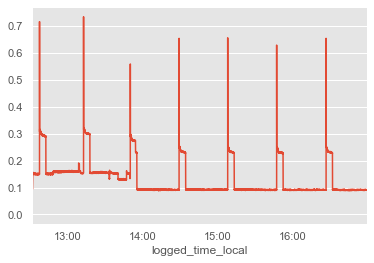

In [10]:
# d=pd.read_csv('onset_label.csv')
# d['logged_time_local']=pd.to_datetime(d['logged_time_local'])
# onset_data=onset_data.sort_values('logged_time_local').set_index('logged_time_local')
stime='2021-02-22 12:30:00'
etime='2021-02-22 16:59:00'
d=onset_data[(onset_data.index<etime) & (onset_data.index>stime)]
d['mains_power'].plot()

In [118]:
x=pivot_data[pivot_data.event_time_utc>'2021-02-25 23:59:50'].sort_values('event_time_utc')
x['event_time_utc']=x['event_time_utc']+datetime.timedelta(hours=5.5)
y=onset_data[onset_data.logged_time_local>'2021-02-25 23:59:50'].sort_values('logged_time_local')

(737848.0, 737849.0)

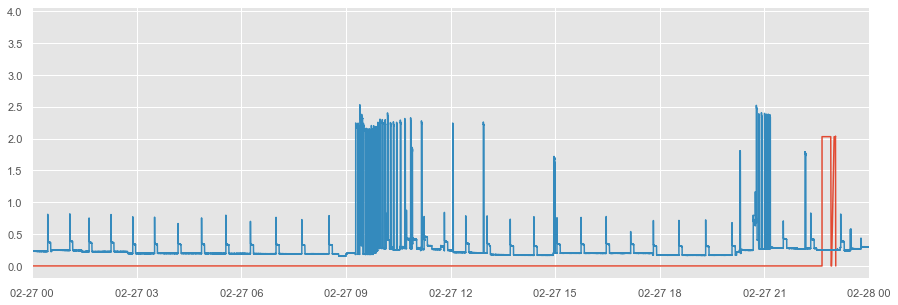

In [119]:
fig,ax=plt.subplots()
fig.set_size_inches(15,5)
# device='bfcb5ddd31910b7db0cata'
device='bf328a81d14dcceb63w5pc'
ax.plot(x[x.device_id==device].event_time_utc,x[x.device_id==device].cur_power/10000)
ax.plot(y.logged_time_local,y.mains_power)
start=pd.to_datetime('2021-02-27')
end=pd.to_datetime('2021-02-28')
ax.set_xlim(start,end)

In [28]:
x.device_id.unique()

array(['7162087750029104969a', '7162087750029107eb1d',
       'bf77c5e5790a5ca71a3vjf', '7162087750029104c109',
       'bfa9489885a2c54078s87z', 'bf328a81d14dcceb63w5pc',
       '71620877500291049610', '7162087750029107ee30',
       'bfcb5ddd31910b7db0cata', '71620877500291089aa5',
       '71620877500291025646'], dtype=object)

In [11]:
onset_data[onset_data.logged_time_local<='2021-01-04'].sort_values('logged_time_local',ascending=False)

,property_id,timestamp,logged_time_local,use,gen,l1_voltage,l2_voltage,l3_voltage,l1_frequency,l2_frequency,...,ct3_amperage,mains_power,mains_power_star,mains_power_factor,month,wday,mday,thd,thd_l2,dump
2374116,1403,1.609718e+09,2021-01-04 00:00:00,0.088000,0.0,232.919006,238.408005,240.548004,51.513004,68.730003,...,0.271000,0.088000,0.117000,0.752000,0,6,3,3.369000,17.412001,NaN
2375197,1403,1.609718e+09,2021-01-03 23:59:59,0.091000,0.0,232.971008,238.531006,240.700012,51.459003,64.091003,...,0.277000,0.091000,0.117000,0.778000,0,6,3,3.318000,18.592001,NaN
2282031,1403,1.609718e+09,2021-01-03 23:59:58,0.089000,0.0,233.346008,238.549011,240.784012,52.491001,62.833004,...,0.275000,0.089000,0.119000,0.748000,0,6,3,11.834001,18.592001,NaN
2337670,1403,1.609718e+09,2021-01-03 23:59:57,0.088000,0.0,233.507004,238.065018,240.423004,50.470001,67.293007,...,0.271000,0.088000,0.115000,0.765000,0,6,3,3.346000,17.358002,NaN
2294595,1403,1.609718e+09,2021-01-03 23:59:56,0.089000,0.0,233.462006,238.036011,240.421005,55.466003,61.592003,...,0.272000,0.089000,0.116000,0.767000,0,6,3,11.214001,10.027000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2009465,20,1.606496e+09,2020-11-27 16:56:00,0.395217,0.0,229.345931,236.581299,235.787891,50.016252,49.656384,...,0.546433,0.395217,0.475133,0.839017,10,4,27,3.838317,7.551117,NaN
1372419,20,1.606496e+09,2020-11-27 16:55:00,0.239067,0.0,228.317708,236.712646,235.614079,49.998901,51.181502,...,0.554683,0.239067,0.268317,0.891067,10,4,27,3.961083,4.283517,NaN
1948600,20,1.606496e+09,2020-11-27 16:54:00,0.238333,0.0,227.671745,235.752799,235.132747,49.957385,51.308252,...,0.554050,0.238333,0.267400,0.891283,10,4,27,3.016067,3.375833,NaN
1329966,20,1.606496e+09,2020-11-27 16:53:00,0.190633,0.0,182.753923,188.662093,187.912142,39.972884,41.598869,...,0.445417,0.190633,0.214683,0.665967,7,3,21,0.000000,0.000000,NaN


In [5]:
onset_data.logged_time_local

0         2020-12-28 13:14:58
1         2020-12-28 13:16:35
2         2020-12-28 13:12:33
3         2020-12-28 13:13:16
4         2020-12-28 13:12:50
                  ...        
5848679   2021-03-03 19:17:51
5848680   2021-03-03 20:08:25
5848681   2021-03-03 19:17:40
5848682   2021-03-03 17:37:42
5848683   2021-03-03 17:38:09
Name: logged_time_local, Length: 5848684, dtype: datetime64[ns]

In [29]:
pivot_data.sort_values('event_time_utc', ascending=False).drop_duplicates(subset='device_id').to_csv('report.csv')

In [57]:
# pivot_data[pivot_data['device_id']=='bf82b4f5ff31b4eb22h036']
pivot_data.sort_values('event_time_utc', ascending=False)

,index,property_id,device_id,event_time_utc,countdown_1,cur_current,cur_power,cur_voltage,switch_1,Date,...,countdown_2,countdown_3,countdown_4,switch_2,switch_3,switch_4,name,device_mean_consumption,consumption_category,type
29,29,1737,bfa9489885a2c54078s87z,2021-03-05 09:38:28.111,NaN,0.0,0.0,2297.0,NaN,2021-03-05,...,NaN,NaN,NaN,NaN,NaN,NaN,smart plug-16A 2,2.0,high,Washing Machine
28,28,1737,bfa9489885a2c54078s87z,2021-03-05 09:17:03.087,NaN,0.0,0.0,2347.0,NaN,2021-03-05,...,NaN,NaN,NaN,NaN,NaN,NaN,smart plug-16A 2,2.0,high,Washing Machine
27,27,1737,bfa9489885a2c54078s87z,2021-03-05 09:15:57.085,NaN,0.0,0.0,2281.0,NaN,2021-03-05,...,NaN,NaN,NaN,NaN,NaN,NaN,smart plug-16A 2,2.0,high,Washing Machine
26,26,1737,bfa9489885a2c54078s87z,2021-03-05 09:02:51.077,NaN,0.0,0.0,2360.0,NaN,2021-03-05,...,NaN,NaN,NaN,NaN,NaN,NaN,smart plug-16A 2,2.0,high,Washing Machine
25,25,1737,bfa9489885a2c54078s87z,2021-03-05 09:01:21.074,NaN,0.0,0.0,2309.0,NaN,2021-03-05,...,NaN,NaN,NaN,NaN,NaN,NaN,smart plug-16A 2,2.0,high,Washing Machine
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
274063,25172,15,bff9556124920d2b243e9f,2020-08-25 20:18:36.555,NaN,8004.0,18897.0,2335.0,1.0,2020-08-25,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
274062,25171,15,bff9556124920d2b243e9f,2020-08-25 20:18:30.511,NaN,8004.0,18897.0,2335.0,0.0,2020-08-25,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
274061,25170,15,bff9556124920d2b243e9f,2020-08-25 20:18:30.508,NaN,8004.0,18897.0,2335.0,0.0,2020-08-25,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
274060,25169,15,bff9556124920d2b243e9f,2020-08-25 20:18:14.083,NaN,8004.0,18897.0,2335.0,NaN,2020-08-25,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
pivot_data

,index,property_id,device_id,event_time_utc,countdown_1,cur_current,cur_power,cur_voltage,switch_1,Date,...,countdown_2,countdown_3,countdown_4,switch_2,switch_3,switch_4,name,device_mean_consumption,consumption_category,type
0,0,1737,bfa9489885a2c54078s87z,2021-03-05 06:58:36.902,0.0,NaN,NaN,NaN,0.0,2021-03-05,...,NaN,NaN,NaN,NaN,NaN,NaN,smart plug-16A 2,2.0,high,Washing Machine
1,1,1737,bfa9489885a2c54078s87z,2021-03-05 06:58:45.910,NaN,0.0,0.0,2413.0,NaN,2021-03-05,...,NaN,NaN,NaN,NaN,NaN,NaN,smart plug-16A 2,2.0,high,Washing Machine
2,2,1737,bfa9489885a2c54078s87z,2021-03-05 07:03:22.917,NaN,0.0,0.0,2360.0,NaN,2021-03-05,...,NaN,NaN,NaN,NaN,NaN,NaN,smart plug-16A 2,2.0,high,Washing Machine
3,3,1737,bfa9489885a2c54078s87z,2021-03-05 07:04:18.920,NaN,0.0,0.0,2431.0,NaN,2021-03-05,...,NaN,NaN,NaN,NaN,NaN,NaN,smart plug-16A 2,2.0,high,Washing Machine
4,4,1737,bfa9489885a2c54078s87z,2021-03-05 07:07:04.929,NaN,0.0,0.0,2373.0,NaN,2021-03-05,...,NaN,NaN,NaN,NaN,NaN,NaN,smart plug-16A 2,2.0,high,Washing Machine
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
346910,98019,1737,bfa9489885a2c54078s87z,2020-12-28 21:39:07.437,NaN,0.0,0.0,2516.0,NaN,2020-12-28,...,NaN,NaN,NaN,NaN,NaN,NaN,smart plug-16A 2,2.0,high,Washing Machine
346911,98020,1737,bfa9489885a2c54078s87z,2020-12-28 21:39:38.038,NaN,0.0,0.0,2463.0,NaN,2020-12-28,...,NaN,NaN,NaN,NaN,NaN,NaN,smart plug-16A 2,2.0,high,Washing Machine
346912,98021,1737,bfa9489885a2c54078s87z,2020-12-28 21:39:45.948,NaN,0.0,0.0,2463.0,NaN,2020-12-28,...,NaN,NaN,NaN,NaN,NaN,NaN,smart plug-16A 2,2.0,high,Washing Machine
346913,98022,1737,bfa9489885a2c54078s87z,2020-12-28 21:40:13.424,NaN,0.0,0.0,2521.0,NaN,2020-12-28,...,NaN,NaN,NaN,NaN,NaN,NaN,smart plug-16A 2,2.0,high,Washing Machine


In [53]:
onset_data[onset_data.logged_time_local>'2021-02-27 05:29:59'].sort_values('logged_time_local').set_index('logged_time_local')[['mains_power','mains_power_star']][:60]

,mains_power,mains_power_star
logged_time_local,,
2021-02-27 05:30:00,0.196,0.274
2021-02-27 05:30:01,0.195,0.272
2021-02-27 05:30:02,0.194,0.274
2021-02-27 05:30:03,0.196,0.272
2021-02-27 05:30:04,0.193,0.273
2021-02-27 05:30:05,0.196,0.272
2021-02-27 05:30:06,0.193,0.273
2021-02-27 05:30:07,0.195,0.272
2021-02-27 05:30:08,0.195,0.273


In [77]:
import requests

In [87]:
import requests
response = requests.get('https://openapi.tuyaeu.com/v1.0/devices/bf82b4f5ff31b4eb22h036/logs?type=7&start_time=1615143839397&end_time=1608706890739000', headers={'Authorization':'d32e267f8ceac9414a57cf1928ce0cfd','sign':'7821AA02E0E15B07E52DFD84956BE6246B5AEAE3CC0F58A59AA8AC6F822D59CD','t':'1615361097808','sign_method':'HMAC-SHA256','client_id':'9n7usd4a9q3v6hshpa2b'})

In [88]:
response.json()

{'code': 1010, 'msg': 'token invalid', 'success': False, 't': 1615361114077}

In [102]:
data=onset_data[(onset_data['logged_time_local']>='2021-01-05 14:30:00') & (onset_data['logged_time_local']<='2021-01-06 14:30:02')]

In [90]:
data=onset_data.sort_values('logged_time_local')[:1000]

In [109]:
data.set_index('logged_time_local').resample('1s').first().interpolate().reset_index()

,logged_time_local,property_id,timestamp,use,gen,l1_voltage,l2_voltage,l3_voltage,l1_frequency,l2_frequency,...,ct3_amperage,mains_power,mains_power_star,mains_power_factor,month,wday,mday,thd,thd_l2,dump
0,2021-01-05 14:30:00,1403.0,1.609857e+09,0.076,0.0,228.671005,238.850006,243.082016,139.573013,53.025002,...,0.254,0.076,0.110,0.691,0.0,1.0,5.0,74.861000,8.863001,NaN
1,2021-01-05 14:30:01,1403.0,1.609857e+09,0.074,0.0,228.688004,238.906006,243.057007,150.492004,51.073002,...,0.255,0.074,0.109,0.679,0.0,1.0,5.0,24.056002,3.302000,NaN
2,2021-01-05 14:30:02,1403.0,1.609857e+09,0.075,0.0,228.715012,238.904007,243.009018,155.859009,52.984001,...,0.256,0.075,0.109,0.688,0.0,1.0,5.0,35.938004,8.670000,NaN
3,2021-01-05 14:30:03,1403.0,1.609857e+09,0.074,0.0,228.703018,238.883011,242.946014,151.651001,54.085003,...,0.255,0.074,0.109,0.679,0.0,1.0,5.0,31.163002,8.718000,NaN
4,2021-01-05 14:30:04,1403.0,1.609857e+09,0.075,0.0,228.821014,238.743011,242.960007,148.383011,51.989002,...,0.255,0.075,0.110,0.682,0.0,1.0,5.0,25.804001,3.292000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86398,2021-01-06 14:29:58,1403.0,1.609943e+09,0.076,0.0,233.817017,239.946014,238.696014,142.724014,50.508003,...,0.248,0.076,0.114,0.667,0.0,2.0,6.0,50.275002,2.086000,NaN
86399,2021-01-06 14:29:59,1403.0,1.609943e+09,0.075,0.0,233.855011,239.932007,238.683014,162.028015,50.518002,...,0.246,0.075,0.112,0.670,0.0,2.0,6.0,89.953003,2.083000,NaN
86400,2021-01-06 14:30:00,1403.0,1.609943e+09,0.076,0.0,233.721008,239.650009,238.700012,153.863007,50.465004,...,0.246,0.076,0.112,0.679,0.0,2.0,6.0,81.299004,2.083000,NaN
86401,2021-01-06 14:30:01,1403.0,1.609943e+09,0.074,0.0,233.935013,239.703018,238.863007,149.777008,50.490002,...,0.245,0.074,0.112,0.661,0.0,2.0,6.0,34.643002,2.180000,NaN


In [106]:
data.sort_values('logged_time_local')

,property_id,timestamp,logged_time_local,use,gen,l1_voltage,l2_voltage,l3_voltage,l1_frequency,l2_frequency,...,ct3_amperage,mains_power,mains_power_star,mains_power_factor,month,wday,mday,thd,thd_l2,dump
2690202,1403,1.609857e+09,2021-01-05 14:30:00,0.076,0.0,228.671005,238.850006,243.082016,139.573013,53.025002,...,0.254,0.076,0.110,0.691,0,1,5,74.861000,8.863001,NaN
2690967,1403,1.609857e+09,2021-01-05 14:30:01,0.074,0.0,228.688004,238.906006,243.057007,150.492004,51.073002,...,0.255,0.074,0.109,0.679,0,1,5,24.056002,3.302000,NaN
2697164,1403,1.609857e+09,2021-01-05 14:30:02,0.075,0.0,228.715012,238.904007,243.009018,155.859009,52.984001,...,0.256,0.075,0.109,0.688,0,1,5,35.938004,8.670000,NaN
2690695,1403,1.609857e+09,2021-01-05 14:30:03,0.074,0.0,228.703018,238.883011,242.946014,151.651001,54.085003,...,0.255,0.074,0.109,0.679,0,1,5,31.163002,8.718000,NaN
2694624,1403,1.609857e+09,2021-01-05 14:30:04,0.075,0.0,228.821014,238.743011,242.960007,148.383011,51.989002,...,0.255,0.075,0.110,0.682,0,1,5,25.804001,3.292000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5756836,1403,1.609943e+09,2021-01-06 14:29:59,0.075,0.0,233.855011,239.932007,238.683014,162.028015,50.518002,...,0.246,0.075,0.112,0.670,0,2,6,89.953003,2.083000,NaN
2756836,1403,1.609943e+09,2021-01-06 14:29:59,0.075,0.0,233.855011,239.932007,238.683014,162.028015,50.518002,...,0.246,0.075,0.112,0.670,0,2,6,89.953003,2.083000,NaN
2756700,1403,1.609943e+09,2021-01-06 14:30:00,0.076,0.0,233.721008,239.650009,238.700012,153.863007,50.465004,...,0.246,0.076,0.112,0.679,0,2,6,81.299004,2.083000,NaN
2772112,1403,1.609943e+09,2021-01-06 14:30:01,0.074,0.0,233.935013,239.703018,238.863007,149.777008,50.490002,...,0.245,0.074,0.112,0.661,0,2,6,34.643002,2.180000,NaN


In [118]:
last_timestamp='2021-03-10'
os.chdir(r'C:\Users\Akshay Gupta\Documents\Projects\Homescape\Vizualisations\Config')
credentials = service_account.Credentials.from_service_account_file('bigqueryauth.json')
project_id = 'solar-222307'
client = bigquery.Client(credentials= credentials,project=project_id)

query_job=client.query('select * from dev_loggers.tuya where event_time_utc>"{}"'.format(last_timestamp))
# query_job=client.query('select * from loggers.tuya')
tuya_data = query_job.result().to_dataframe() 

os.chdir(r"C:\Users\Akshay Gupta\Documents\Projects\Homescape\OnSet\Data")
if len(tuya_data)>0:
    tuya_data['value']=tuya_data['value'].replace('true','1').replace('false','0')
    tuya_data['value']=tuya_data['value'].astype(float)
    tuya_data['event_time_utc']=pd.to_datetime(tuya_data['event_time_utc'])
    tuya_data['event_time_utc']=tuya_data['event_time_utc']+datetime.timedelta(hours=5.5)
    tuya_data=tuya_data.drop_duplicates(subset=['device_id','event_timestamp','code','value'])


    pivot_data=tuya_data.pivot_table(index=['property_id','device_id','event_time_utc'], columns='code', values='value')
    pivot_data=pivot_data.reset_index()
    pivot_data['Date']=[i.date() for i in pivot_data['event_time_utc']]

#     for i,j in pivot_data[['device_id','property_id']].drop_duplicates().itertuples(index=False):
#         pivot_data.loc[(pivot_data.device_id==i) & (pivot_data.property_id==j), 'cur_voltage']=pivot_data.loc[(pivot_data.device_id==i) & (pivot_data.property_id==j), 'cur_voltage'].fillna(method='ffill')
#         pivot_data.loc[(pivot_data.device_id==i) & (pivot_data.property_id==j), 'cur_power']=pivot_data.loc[(pivot_data.device_id==i) & (pivot_data.property_id==j), 'cur_power'].fillna(method='ffill')
#         pivot_data.loc[(pivot_data.device_id==i) & (pivot_data.property_id==j), 'cur_current']=pivot_data.loc[(pivot_data.device_id==i) & (pivot_data.property_id==j), 'cur_current'].fillna(method='ffill')


    pivot_data['Month'] = [i.month for i in pivot_data['event_time_utc']]
    pivot_data['Week'] = [i.week for i in pivot_data['event_time_utc']]
    pivot_data['Year'] = [i.year for i in pivot_data['event_time_utc']]
    
pivot_data


code,property_id,device_id,event_time_utc,add_ele,countdown_1,cur_current,cur_power,cur_voltage,switch_1,Date,Month,Week,Year
0,15,bf425667df5e89d62fhjvu,2021-03-10 20:14:23.755,NaN,0.0,NaN,NaN,NaN,1.0,2021-03-10,3,10,2021
1,15,bf425667df5e89d62fhjvu,2021-03-10 20:14:28.714,NaN,NaN,81.0,173.0,2466.0,NaN,2021-03-10,3,10,2021
2,15,bf425667df5e89d62fhjvu,2021-03-10 20:14:58.579,NaN,NaN,5798.0,12056.0,2421.0,NaN,2021-03-10,3,10,2021
3,15,bf425667df5e89d62fhjvu,2021-03-10 20:17:36.577,NaN,NaN,6199.0,13281.0,2408.0,NaN,2021-03-10,3,10,2021
4,15,bf425667df5e89d62fhjvu,2021-03-10 20:19:15.581,100.0,NaN,NaN,NaN,NaN,NaN,2021-03-10,3,10,2021
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2913,20,32750035500291025a61,2021-04-05 12:53:11.684,NaN,NaN,NaN,723.0,NaN,NaN,2021-04-05,4,14,2021
2914,20,32750035500291025a61,2021-04-05 12:57:00.668,36.0,NaN,NaN,NaN,NaN,NaN,2021-04-05,4,14,2021
2915,20,32750035500291025a61,2021-04-05 13:04:35.953,NaN,NaN,NaN,NaN,NaN,0.0,2021-04-05,4,14,2021
2916,20,32750035500291025a61,2021-04-05 13:04:39.549,NaN,NaN,NaN,NaN,NaN,1.0,2021-04-05,4,14,2021


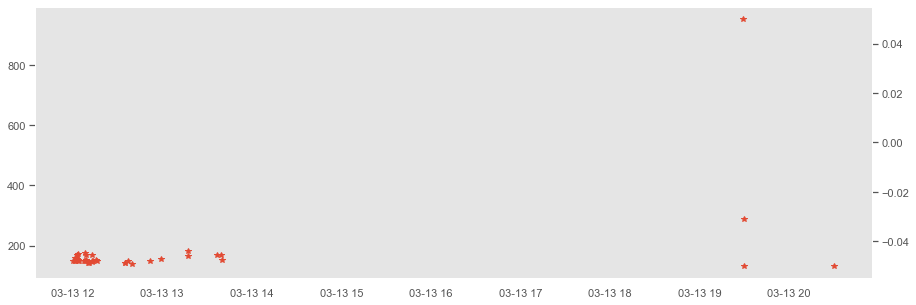

In [124]:
stime='2021-03-13 12:00:00'
etime='2021-03-14 00:00:00'
tuya_test=pivot_data.sort_values('event_time_utc')[(pivot_data.event_time_utc>stime) & (pivot_data.event_time_utc<etime)].set_index('event_time_utc')
tuya_test['time_difference_minutes']=tuya_test.reset_index().event_time_utc.diff().fillna(pd.Timedelta(seconds=0)).apply(lambda x:x.total_seconds()/60).values
# tuya_test.cur_power.plot()
fig,ax=plt.subplots()
temp1=tuya_test.cur_power
temp2=tuya_test.switch_1

ax2=ax.twinx()
fig.set_size_inches(15,5)

ax.plot(temp1[temp1>0].index,temp1[temp1>0],marker='*', lw=0)
ax2.plot(temp2.index,temp2,marker='o', lw=0, color='blue',ms=5)
ax.grid('')
ax2.grid('')

In [105]:
for i in list(tuya_test.reset_index()[tuya_test.reset_index()['time_difference_minutes']>61].index):
    print(tuya_test.reset_index().cur_power[i-1], tuya_test.reset_index().cur_power[i],tuya_test.reset_index().cur_power[i+1], tuya_test.reset_index().switch_1[i-1],tuya_test.reset_index().switch_1[i],tuya_test.reset_index().switch_1[i+1])

In [106]:
tuya_test

code,property_id,device_id,add_ele,countdown_1,cur_current,cur_power,cur_voltage,switch_1,Date,Month,Week,Year,time_difference_minutes
event_time_utc,,,,,,,,,,,,,
2021-03-17 11:28:37.060,20,32750035500291025a61,NaN,0.0,0.0,0.0,2230.0,1.0,2021-03-17,3,11,2021,0.000000
2021-03-17 11:28:37.399,20,32750035500291025a61,NaN,NaN,0.0,0.0,2230.0,NaN,2021-03-17,3,11,2021,0.005650
2021-03-17 12:00:13.523,20,32750035500291025a61,NaN,NaN,59.0,56.0,2226.0,NaN,2021-03-17,3,11,2021,31.602067
2021-03-17 12:00:18.539,20,32750035500291025a61,NaN,NaN,483.0,938.0,2226.0,NaN,2021-03-17,3,11,2021,0.083600
2021-03-17 12:00:23.548,20,32750035500291025a61,NaN,NaN,4.0,56.0,2226.0,NaN,2021-03-17,3,11,2021,0.083483
2021-03-17 12:00:28.557,20,32750035500291025a61,NaN,NaN,0.0,0.0,2226.0,NaN,2021-03-17,3,11,2021,0.083483


In [74]:
tuya_data[tuya_data.code=='add_ele'].sort_values('event_time_utc')

,property_id,device_id,code,event_from,event_id,event_timestamp,event_time_utc,status,value
726,15,bf425667df5e89d62fhjvu,add_ele,1,7,1615387755581,2021-03-10 14:49:15.581,1,100.0
1294,15,bf425667df5e89d62fhjvu,add_ele,1,7,1615389556827,2021-03-10 15:19:16.827,1,81.0
948,15,bf425667df5e89d62fhjvu,add_ele,1,7,1615391355129,2021-03-10 15:49:15.129,1,7.0
1019,15,bf425667df5e89d62fhjvu,add_ele,1,7,1615393156430,2021-03-10 16:19:16.430,1,9.0
979,15,bf425667df5e89d62fhjvu,add_ele,1,7,1615394957709,2021-03-10 16:49:17.709,1,8.0
...,...,...,...,...,...,...,...,...,...
364,20,32750035500291025a61,add_ele,1,7,1615860354111,2021-03-16 02:05:54.111,1,37.0
350,20,32750035500291025a61,add_ele,1,7,1615862154325,2021-03-16 02:35:54.325,1,5.0
1960,20,32750035500291025a61,add_ele,1,7,1615872648691,2021-03-16 05:30:48.691,1,37.0
1952,20,32750035500291025a61,add_ele,1,7,1615874449307,2021-03-16 06:00:49.307,1,12.0


In [5]:
data=pivot_data[pivot_data['device_id']=='32750035500291025a61'].sort_values('event_time_utc')
data
# data['time_difference_minutes_succeeding']=data.reset_index().event_time_utc.diff().fillna(pd.Timedelta(seconds=0)).apply(lambda x:x.total_seconds()/60).values
# data['time_difference_minutes_preceding']=data.reset_index().event_time_utc.diff(periods=-1).fillna(pd.Timedelta(seconds=0)).apply(lambda x:x.total_seconds()/60).values
# data['active']=data['switch_1']
# data.loc[data['time_difference_minutes_succeeding']>65,'active']=1
# data.loc[data['time_difference_minutes_preceding']<-65,'active']=0

,index,property_id,device_id,event_time_utc,add_ele,countdown_1,cur_current,cur_power,cur_voltage,switch_1,Date,Month,Week,Year,countdown_2,countdown_3,countdown_4,switch_2,switch_3,switch_4
294196,43395,1403,32750035500291025a61,2020-12-22 21:30:05.854,NaN,NaN,0.0,0.0,2289.0,NaN,2020-12-22,12,52,2020,NaN,NaN,NaN,NaN,NaN,NaN
294197,43396,1403,32750035500291025a61,2020-12-22 21:30:06.030,NaN,0.0,0.0,0.0,2289.0,0.0,2020-12-22,12,52,2020,NaN,NaN,NaN,NaN,NaN,NaN
294198,43397,1403,32750035500291025a61,2020-12-22 21:30:12.691,NaN,NaN,0.0,0.0,2289.0,1.0,2020-12-22,12,52,2020,NaN,NaN,NaN,NaN,NaN,NaN
294199,43398,1403,32750035500291025a61,2020-12-22 21:30:34.537,4.0,NaN,0.0,0.0,2289.0,NaN,2020-12-22,12,52,2020,NaN,NaN,NaN,NaN,NaN,NaN
294200,43399,1403,32750035500291025a61,2020-12-22 21:30:35.816,NaN,0.0,0.0,0.0,2289.0,1.0,2020-12-22,12,52,2020,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1185,8,1403,32750035500291025a61,2021-03-12 19:04:06.920,7.0,NaN,169.0,132.0,2226.0,NaN,2021-03-12,3,10,2021,NaN,NaN,NaN,NaN,NaN,NaN
1186,9,1403,32750035500291025a61,2021-03-12 19:22:35.127,NaN,NaN,169.0,66.0,2230.0,NaN,2021-03-12,3,10,2021,NaN,NaN,NaN,NaN,NaN,NaN
1187,10,1403,32750035500291025a61,2021-03-12 19:22:40.146,NaN,NaN,0.0,0.0,2230.0,NaN,2021-03-12,3,10,2021,NaN,NaN,NaN,NaN,NaN,NaN
1188,11,1403,32750035500291025a61,2021-03-12 19:34:06.190,4.0,NaN,0.0,0.0,2230.0,NaN,2021-03-12,3,10,2021,NaN,NaN,NaN,NaN,NaN,NaN


In [112]:
data['active']=0

prev_timestamp=data.event_time_utc.values[0]
prev_state=data.loc[data['event_time_utc']==prev_timestamp,'switch_1'].values[0]
cur_state=data.loc[data['event_time_utc']==prev_timestamp,'switch_1'].values[0]
for i in data.event_time_utc.iloc[1:]:
    cur_timestamp=i
    if ((data.loc[data['event_time_utc']==cur_timestamp,'switch_1']==1) | (data.loc[data['event_time_utc']==cur_timestamp,'cur_power'].fillna(0)>0)).values[0]:
        cur_state=1
    
    if ((cur_timestamp-prev_timestamp).seconds>3700) & (prev_state==1):
        data.loc[data['event_time_utc']==prev_timestamp,'active']==0
        cur_state=0
    data.loc[data['event_time_utc']==cur_timestamp,'active']=cur_state
    prev_state=cur_state
    prev_timestamp=cur_timestamp

In [99]:
cur_timestamp=i
if ((data.loc[data['event_time_utc']==cur_timestamp,'switch_1']==1) | (data.loc[data['event_time_utc']==cur_timestamp,'cur_power']>0)).values[0]:
    cur_state=1

if ((cur_timestamp-prev_timestamp).seconds>3700) & (prev_state==1):
    data.loc[data['event_time_utc']==prev_timestamp,'active']==0
    cur_state=0
data.loc[data['event_time_utc']==cur_timestamp,'active']==cur_state

2910    True
Name: active, dtype: bool

In [100]:
data['active'].unique()

array([0., 1.])

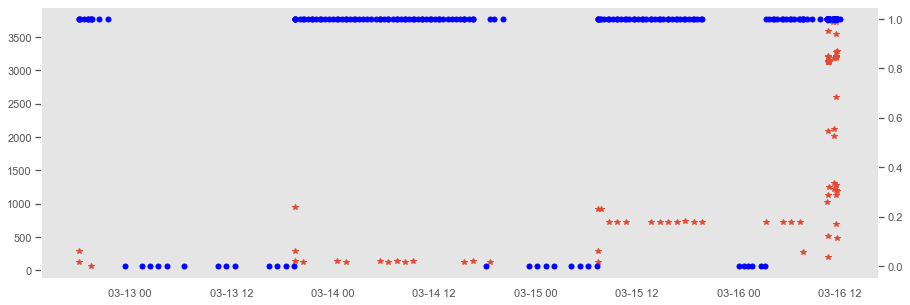

In [115]:
stime='2021-03-12 18:00:00'
etime='2021-03-16 22:00:00'
tuya_test=data.sort_values('event_time_utc')[(data.event_time_utc>stime) & (data.event_time_utc<etime)].set_index('event_time_utc')
tuya_test['time_difference_minutes']=tuya_test.reset_index().event_time_utc.diff().fillna(pd.Timedelta(seconds=0)).apply(lambda x:x.total_seconds()/60).values
# tuya_test.cur_power.plot()
fig,ax=plt.subplots()
temp1=tuya_test.cur_power
temp2=tuya_test.active

ax2=ax.twinx()
fig.set_size_inches(15,5)

ax.plot(temp1[temp1>0].index,temp1[temp1>0],marker='*', lw=0)
ax2.plot(temp2.index,temp2,marker='o', lw=0, color='blue',ms=5)
ax.grid('')
ax2.grid('')

In [7]:
for device,df_device in pivot_data.groupby('device_id'):
    
    for i in range(len)

        index  property_id             device_id          event_time_utc  \
20          0         1403  010246052cf4323c07f8 2021-03-18 13:21:37.829   
21          1         1403  010246052cf4323c07f8 2021-03-18 13:22:05.087   
22          2         1403  010246052cf4323c07f8 2021-03-18 13:22:11.703   
23          3         1403  010246052cf4323c07f8 2021-03-18 13:22:17.192   
24          4         1403  010246052cf4323c07f8 2021-03-18 13:22:24.445   
...       ...          ...                   ...                     ...   
246545      6         1403  010246052cf4323c07f8 2020-12-29 11:00:35.972   
246546      7         1403  010246052cf4323c07f8 2020-12-29 12:00:39.972   
246547      8         1403  010246052cf4323c07f8 2020-12-29 12:00:40.836   
246548      9         1403  010246052cf4323c07f8 2020-12-29 12:00:41.096   
246549     10         1403  010246052cf4323c07f8 2020-12-29 12:00:41.315   

        add_ele  countdown_1  cur_current  cur_power  cur_voltage  switch_1  \
20      

In [4]:
pivot_data

,index,property_id,device_id,event_time_utc,add_ele,countdown_1,cur_current,cur_power,cur_voltage,switch_1,Date,Month,Week,Year,countdown_2,countdown_3,countdown_4,switch_2,switch_3,switch_4
0,0,1737,bf425667df5e89d62fhjvu,2021-04-05 13:38:41.982,9.0,NaN,NaN,NaN,NaN,NaN,2021-04-05,4,14,2021,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1737,bf425667df5e89d62fhjvu,2021-04-05 13:50:58.247,NaN,NaN,69.0,166.0,2470.0,NaN,2021-04-05,4,14,2021,NaN,NaN,NaN,NaN,NaN,NaN
2,2,1737,bf425667df5e89d62fhjvu,2021-04-05 13:51:28.259,NaN,NaN,85.0,158.0,2434.0,NaN,2021-04-05,4,14,2021,NaN,NaN,NaN,NaN,NaN,NaN
3,3,1737,bf425667df5e89d62fhjvu,2021-04-05 13:52:50.835,NaN,NaN,76.0,162.0,2443.0,NaN,2021-04-05,4,14,2021,NaN,NaN,NaN,NaN,NaN,NaN
4,4,1737,bf425667df5e89d62fhjvu,2021-04-05 13:52:50.837,NaN,NaN,76.0,162.0,2443.0,NaN,2021-04-05,4,14,2021,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
348820,98019,1737,bfa9489885a2c54078s87z,2020-12-28 21:39:07.437,NaN,NaN,0.0,0.0,2516.0,NaN,2020-12-28,12,53,2020,NaN,NaN,NaN,NaN,NaN,NaN
348821,98020,1737,bfa9489885a2c54078s87z,2020-12-28 21:39:38.038,NaN,NaN,0.0,0.0,2463.0,NaN,2020-12-28,12,53,2020,NaN,NaN,NaN,NaN,NaN,NaN
348822,98021,1737,bfa9489885a2c54078s87z,2020-12-28 21:39:45.948,NaN,NaN,0.0,0.0,2463.0,NaN,2020-12-28,12,53,2020,NaN,NaN,NaN,NaN,NaN,NaN
348823,98022,1737,bfa9489885a2c54078s87z,2020-12-28 21:40:13.424,NaN,NaN,0.0,0.0,2521.0,NaN,2020-12-28,12,53,2020,NaN,NaN,NaN,NaN,NaN,NaN


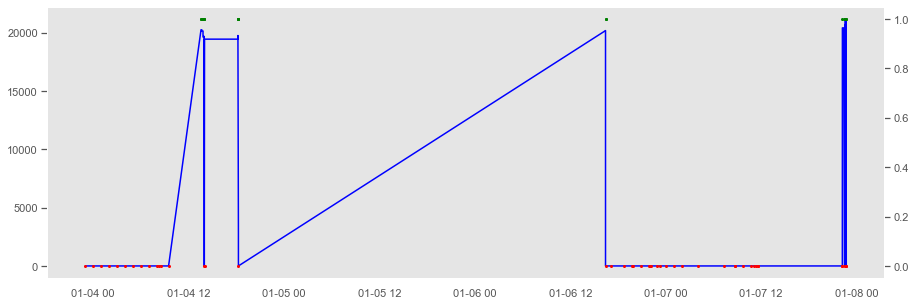

In [93]:
data=pivot_data[pivot_data['device_id']=='32750035500291025a61'].sort_values('event_time_utc').dropna(subset=['cur_power'])
data['time_difference_minutes_succeeding']=data.reset_index().event_time_utc.diff().fillna(pd.Timedelta(seconds=0)).apply(lambda x:x.total_seconds()/60).values
data['time_difference_minutes_preceding']=data.reset_index().event_time_utc.diff(periods=-1).fillna(pd.Timedelta(seconds=0)).apply(lambda x:x.total_seconds()/60).values
data['active']=1
# data.loc[data['time_difference_minutes_succeeding']>65,'active']=0
data.loc[data['time_difference_minutes_preceding']<-65,'active']=0
data.loc[data['cur_power']==0,'active']=0


data=data[60:130]
fig,ax=plt.subplots()
fig.set_size_inches(15,5)
ax2=ax.twinx()


ax.plot(data.event_time_utc,data.cur_power,color='blue')
ax2.plot(data.event_time_utc[data.active==1],data.active[data.active==1],color='green',lw=0,ms=2,marker='o')
ax2.plot(data.event_time_utc[data.active==0],data.active[data.active==0],color='red',lw=0,ms=2,marker='o')
ax.grid('')
ax2.grid('')

In [57]:
data[['cur_power','event_time_utc','switch_1','active','time_difference_minutes_preceding']]

,cur_power,event_time_utc,switch_1,active,time_difference_minutes_preceding
162350,0.0,2021-01-08 13:07:00.293,NaN,0,-68.990583
162351,20620.0,2021-01-08 14:15:59.728,NaN,1,-4.366783
162352,0.0,2021-01-08 14:20:21.735,NaN,0,-53.706783
162353,20448.0,2021-01-08 15:14:04.142,NaN,1,-1.283483
162354,4837.0,2021-01-08 15:15:21.151,NaN,1,-0.083500
162355,0.0,2021-01-08 15:15:26.161,NaN,0,-81.954283
162356,0.0,2021-01-08 16:37:23.418,1.0,0,-0.088550
162357,0.0,2021-01-08 16:37:28.731,NaN,0,-59.997833
162358,0.0,2021-01-08 17:37:28.601,NaN,0,-0.683683
162359,19478.0,2021-01-08 17:38:09.622,NaN,1,-1.367017


In [66]:
data

,index,property_id,device_id,event_time_utc,add_ele,countdown_1,cur_current,cur_power,cur_voltage,switch_1,...,Year,countdown_2,countdown_3,countdown_4,switch_2,switch_3,switch_4,time_difference_minutes_succeeding,time_difference_minutes_preceding,active
162350,9,1403,32750035500291025a61,2021-01-08 13:07:00.293,NaN,NaN,0.0,0.0,2365.0,NaN,...,2021,NaN,NaN,NaN,NaN,NaN,NaN,14.783650,-68.990583,0
162351,10,1403,32750035500291025a61,2021-01-08 14:15:59.728,NaN,NaN,8809.0,20620.0,2318.0,NaN,...,2021,NaN,NaN,NaN,NaN,NaN,NaN,68.990583,-4.366783,1
162352,11,1403,32750035500291025a61,2021-01-08 14:20:21.735,NaN,NaN,0.0,0.0,2387.0,NaN,...,2021,NaN,NaN,NaN,NaN,NaN,NaN,4.366783,-53.706783,0
162353,12,1403,32750035500291025a61,2021-01-08 15:14:04.142,NaN,NaN,8906.0,20448.0,2378.0,NaN,...,2021,NaN,NaN,NaN,NaN,NaN,NaN,53.706783,-1.283483,1
162354,13,1403,32750035500291025a61,2021-01-08 15:15:21.151,NaN,NaN,6.0,4837.0,2343.0,NaN,...,2021,NaN,NaN,NaN,NaN,NaN,NaN,1.283483,-0.083500,1
162355,14,1403,32750035500291025a61,2021-01-08 15:15:26.161,NaN,NaN,0.0,0.0,2373.0,NaN,...,2021,NaN,NaN,NaN,NaN,NaN,NaN,0.083500,-81.954283,0
162356,15,1403,32750035500291025a61,2021-01-08 16:37:23.418,NaN,0.0,0.0,0.0,2373.0,1.0,...,2021,NaN,NaN,NaN,NaN,NaN,NaN,81.954283,-0.088550,0
162357,16,1403,32750035500291025a61,2021-01-08 16:37:28.731,NaN,NaN,0.0,0.0,2335.0,NaN,...,2021,NaN,NaN,NaN,NaN,NaN,NaN,0.088550,-59.997833,0
162358,17,1403,32750035500291025a61,2021-01-08 17:37:28.601,NaN,NaN,0.0,0.0,2314.0,NaN,...,2021,NaN,NaN,NaN,NaN,NaN,NaN,59.997833,-0.683683,0
162359,18,1403,32750035500291025a61,2021-01-08 17:38:09.622,NaN,NaN,8676.0,19478.0,2314.0,NaN,...,2021,NaN,NaN,NaN,NaN,NaN,NaN,0.683683,-1.367017,1


In [117]:
def calculate_device_energy(device,start,end,prop_id,pivot_data,period='daily'):
    pivot_data['event_time_utc']=pd.to_datetime(pivot_data['event_time_utc'])
    mask=(pivot_data['device_id']==device) & (pivot_data['event_time_utc']>=pd.to_datetime(start)) & (pivot_data['event_time_utc']<=pd.to_datetime(end)) & (pivot_data['property_id']==prop_id)
    data=pivot_data[mask].sort_values('event_time_utc').dropna(subset=['cur_power']) 
    data['time_difference_minutes_preceding']=data.reset_index().event_time_utc.diff(periods=-1).fillna(pd.Timedelta(seconds=0)).apply(lambda x:x.total_seconds()/60).values
    data['active']=1
    data.loc[data['time_difference_minutes_preceding']< -61,'active']=0
    data.loc[data['cur_power']==0,'active']=0
    
    data=data.reset_index()
    device_energy=0
    data_length=len(data)
    data['cur_energy']=0
    for i in data[data['active']==1].index:
#         print(data.sort_index())
        if i!=data_length-1:
            if data.loc[i,'time_difference_minutes_preceding']>=-61:
#                 device_energy=device_energy+(data.loc[i,'cur_power']/10000)*((data.loc[i+1,'event_time_utc']-data.loc[i,'event_time_utc']).seconds/3600)
                data.loc[i,'cur_energy']=device_energy+(data.loc[i,'cur_power']/10000)*((data.loc[i+1,'event_time_utc']-data.loc[i,'event_time_utc']).seconds/3600)
    if period.lower()=='daily':
        device_energy=data.set_index('event_time_utc')['cur_energy'].resample('1h').sum()
    else:
        device_energy=data.set_index('event_time_utc')['cur_energy'].resample('1d').sum()
    
    return device_energy


# m=calculate_device_energy('32750035500291025a61','2020-01-01 13:07:00.293','2022-03-19 22:09:01.873',1403,pivot_data)
# print(m)


event_time_utc
2020-12-22 21:00:00    0.000000
2020-12-22 22:00:00    0.000000
2020-12-22 23:00:00    0.000000
2020-12-23 00:00:00    0.000000
2020-12-23 01:00:00    0.000000
                         ...   
2021-03-12 16:00:00    0.000000
2021-03-12 17:00:00    0.000783
2021-03-12 18:00:00    0.013442
2021-03-12 19:00:00    0.004765
2021-03-12 20:00:00    0.000000
Freq: H, Name: cur_energy, Length: 1920, dtype: float64


In [103]:
data.loc[248232]

KeyError: 248232

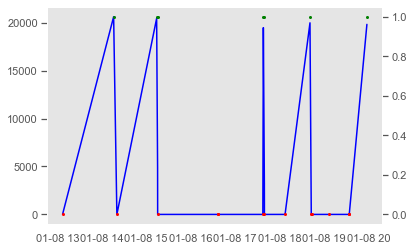

In [87]:
fig,ax=plt.subplots()
ax2=ax.twinx()

temp= y[:20]
ax.plot(temp.event_time_utc,temp.cur_power,color='blue')
ax2.plot(temp.event_time_utc[temp.active==1],temp.active[temp.active==1],color='green',lw=0,ms=2,marker='o')
ax2.plot(temp.event_time_utc[temp.active==0],temp.active[temp.active==0],color='red',lw=0,ms=2,marker='o')
ax.grid('')
ax2.grid('')

In [72]:
x.seconds

4139

In [59]:
pivot_data.device_id.unique()

array(['bf425667df5e89d62fhjvu', '010246052cf4323c07f8',
       'bfa9489885a2c54078s87z', '32750035500291025a61',
       '71620877500291025646', '71620877500291049610',
       '7162087750029104969a', '7162087750029104c109',
       '7162087750029107eb1d', '7162087750029107ee30',
       '71620877500291089aa5', 'bf328a81d14dcceb63w5pc',
       'bf77c5e5790a5ca71a3vjf', 'bfcb5ddd31910b7db0cata',
       '71620877500291025128', '71620877500291024eec',
       '71620877500291025109', '7162087750029107e916',
       '71620877500291089a0b', 'bf0134d5ee7fcae5edmigl',
       '716208775002910494dd', '71620877500291089a33',
       'bf0d93aeb7379409bclvge', 'bf9882ef90bc93335en4ah',
       '7162087750029102561e', 'bff9556124920d2b243e9f',
       'bf00ca65918465894cuacn', 'bf557926b9df9bf703acyh',
       'bf603922278a45c9449gvo', 'bfae35261c95f273054pxp',
       'bff8ea23065e676885ikbk'], dtype=object)

In [7]:
# os.chdir(r'C:\Users\Akshay Gupta\Documents\Projects\Homescape\Vizualisations\Config')
# credentials = service_account.Credentials.from_service_account_file('bigqueryauth.json')
# project_id = 'solar-222307'
# client = bigquery.Client(credentials= credentials,project=project_id)

# query_job=client.query('select * from dev_loggers.tuya where event_time_utc>"2021-03-01"')
# pivot_data = query_job.result().to_dataframe() 

dataframe=pivot_data
pivot_data=pivot_data.sort_values('event_time_utc')
dataframe['key'] = [int(i.timestamp()) for i in dataframe['event_time_utc']] # key in utc timestamp
data = {}
for device_id, df in dataframe.groupby('device_id'):
    device_data = {}
    for code, d in df.groupby('code'):
        d = d[['value', 'key']].drop_duplicates()
        if code in ['cur_power', 'cur_voltage', 'cur_current']:
            # filter tuya data in between 5% to 95%
            d['value']=d['value'].astype('float')
            lower_qr = d['value'].quantile(0.05)
            upper_qr = d['value'].quantile(0.95)
            d = d[(d['value'] >= lower_qr) & (d['value'] <= upper_qr)].drop_duplicates()
        device_data[code] = [{str(row['key']): row['value']} for index,row in d.iterrows()]
    if 'cur_power' in df['code'].unique():
        device_data['cur_energy']=calculate_device_energy(df)
    data[device_id] = device_data


In [162]:
# pivot_data[(pivot_data['device_id']=='32750035500291025a61') & (pivot_data['code']=='cur_power')]
# pd.Series(device_data['cur'])
# pd.Series(device_data['cur_energy'])
# device_data.keys()
# df
# device_id
data['bf425667df5e89d62fhjvu']

{'add_ele': [{'1615468788': '7'},
  {'1615470589': '7'},
  {'1615475990': '7'},
  {'1615391355': '7'},
  {'1615425569': '7'},
  {'1615443582': '7'},
  {'1615441771': '7'},
  {'1615430970': '7'},
  {'1615429170': '7'},
  {'1615439972': '7'},
  {'1615432770': '7'},
  {'1615436371': '7'},
  {'1615454383': '7'},
  {'1615447182': '7'},
  {'1615463388': '7'},
  {'1615522801': '7'},
  {'1615524602': '7'},
  {'1615521002': '7'},
  {'1615512001': '7'},
  {'1615515601': '7'},
  {'1615517401': '7'},
  {'1615600011': '7'},
  {'1615601812': '7'},
  {'1615540601': '7'},
  {'1615556804': '7'},
  {'1615549603': '7'},
  {'1615555003': '7'},
  {'1615533400': '7'},
  {'1615618014': '7'},
  {'1615614413': '7'},
  {'1615612613': '7'},
  {'1615607212': '7'},
  {'1615609013': '7'},
  {'1615610813': '7'},
  {'1615621615': '7'},
  {'1617218144': '7'},
  {'1617267919': '7'},
  {'1617285750': '7'},
  {'1617289351': '7'},
  {'1617287550': '7'},
  {'1617283950': '7'},
  {'1617280349': '7'},
  {'1617302800': '7'},


In [8]:
data

{'32750035500291025a61': {'add_ele': [{'1615552444': '2'},
   {'1615644247': '2'},
   {'1615773941': '3'},
   {'1615557846': '4'},
   {'1616149488': '4'},
   {'1615862154': '5'},
   {'1615969706': '5'},
   {'1616145888': '5'},
   {'1615530760': '6'},
   {'1615537961': '6'},
   {'1615554246': '6'},
   {'1615534360': '6'},
   {'1615692857': '6'},
   {'1615651449': '6'},
   {'1615656850': '6'},
   {'1615662251': '6'},
   {'1615687456': '6'},
   {'1615698258': '6'},
   {'1615673054': '6'},
   {'1615667652': '6'},
   {'1615682055': '6'},
   {'1615678455': '6'},
   {'1615646049': '6'},
   {'1615703659': '6'},
   {'1615719861': '6'},
   {'1615709059': '6'},
   {'1615714460': '6'},
   {'1615876249': '6'},
   {'1616295307': '6'},
   {'1616284506': '6'},
   {'1616289906': '6'},
   {'1616273705': '6'},
   {'1616279105': '6'},
   {'1616264703': '6'},
   {'1616268304': '6'},
   {'1616153089': '6'},
   {'1616144088': '6'},
   {'1616138687': '6'},
   {'1616300708': '6'},
   {'1616311509': '6'},
   {'

In [149]:
pd.Series(calculate_device_energy(pivot_data[pivot_data['device_id']=='bf82b4f5ff31b4eb22h036']))
pivot_data[pivot_data['device_id']=='bf82b4f5ff31b4eb22h036'][pivot_data['code']=='cur_power'].drop_duplicates('event_time_utc')

,property_id,device_id,code,event_from,event_id,event_timestamp,event_time_utc,status,value,key
9550,923,bf82b4f5ff31b4eb22h036,cur_power,1,7,1617791548777,2021-04-07 10:32:28.777,1,0,1617791548
9549,923,bf82b4f5ff31b4eb22h036,cur_power,1,7,1617792448430,2021-04-07 10:47:28.430,1,0,1617792448
9551,923,bf82b4f5ff31b4eb22h036,cur_power,1,7,1617792590808,2021-04-07 10:49:50.808,1,0,1617792590
9543,923,bf82b4f5ff31b4eb22h036,cur_power,1,7,1617793187750,2021-04-07 10:59:47.750,1,0,1617793187
9541,923,bf82b4f5ff31b4eb22h036,cur_power,1,7,1617794515227,2021-04-07 11:21:55.227,1,0,1617794515
...,...,...,...,...,...,...,...,...,...,...
14,923,bf82b4f5ff31b4eb22h036,cur_power,1,7,1623031728949,2021-06-07 02:08:48.949,1,3509,1623031728
6,923,bf82b4f5ff31b4eb22h036,cur_power,1,7,1623032247109,2021-06-07 02:17:27.109,1,3129,1623032247
3,923,bf82b4f5ff31b4eb22h036,cur_power,1,7,1623032491109,2021-06-07 02:21:31.109,1,2783,1623032491
16,923,bf82b4f5ff31b4eb22h036,cur_power,1,7,1623034058281,2021-06-07 02:47:38.281,1,3097,1623034058


In [5]:
def calculate_device_energy(input_data):

    input_data=input_data[input_data['code']=='cur_power']
    input_data=input_data.drop_duplicates(subset=['key'])
    input_data['cur_power']=input_data['value']
    input_data['cur_power']=input_data['cur_power'].astype(float)
    input_data['event_time_utc']=pd.to_datetime(input_data['event_time_utc'])
    input_data=input_data.reset_index()
    data=input_data.sort_values('event_time_utc').dropna(subset=['cur_power']) 
    data['time_difference_minutes_preceding']=data.reset_index().event_time_utc.diff(periods=-1).fillna(pd.Timedelta(seconds=0)).apply(lambda x:x.total_seconds()/60).values
    data['active']=1
    data.loc[data['time_difference_minutes_preceding']< -61,'active']=0
    data.loc[data['cur_power']==0,'active']=0
    data=data.reset_index()

    data['cur_energy']=0
    energy=[]
    for i in range(len(data)-1):
        if data['cur_power'].iloc[i]!=0:
            if data['time_difference_minutes_preceding'].iloc[i]>=-61:
                energy.append((data['cur_power'].iloc[i]/10000)*((data['event_time_utc'].iloc[i+1]-data['event_time_utc'].iloc[i]).seconds/3600))
            else:
                energy.append(0)
        else:
            energy.append(0)
            
    energy.append(0)
    data['cur_energy']=energy
    
    return [{str(row['key']): row['cur_energy']} for index,row in data.iterrows()]


In [21]:
pivot_data

,property_id,device_id,code,event_from,event_id,event_timestamp,event_time_utc,status,value,key
0,923,bf82b4f5ff31b4eb22h036,cur_power,1,7,1623034088285,2021-06-07 02:48:08.285,1,2955,1623034088
1,923,bf82b4f5ff31b4eb22h036,cur_voltage,1,7,1623034058281,2021-06-07 02:47:38.281,1,2288,1623034058
2,923,bf82b4f5ff31b4eb22h036,cur_voltage,1,7,1623032491109,2021-06-07 02:21:31.109,1,2292,1623032491
3,923,bf82b4f5ff31b4eb22h036,cur_power,1,7,1623032491109,2021-06-07 02:21:31.109,1,2783,1623032491
4,923,bf82b4f5ff31b4eb22h036,add_ele,1,7,1623031879954,2021-06-07 02:11:19.954,1,100,1623031879
...,...,...,...,...,...,...,...,...,...,...
512634,923,bf82b4f5ff31b4eb22h036,cur_current,1,7,1621541289662,2021-05-20 20:08:09.662,1,111,1621541289
512635,923,bf82b4f5ff31b4eb22h036,cur_current,1,7,1621541289662,2021-05-20 20:08:09.662,1,111,1621541289
512636,923,bf82b4f5ff31b4eb22h036,cur_current,1,7,1621541289662,2021-05-20 20:08:09.662,1,111,1621541289
512637,923,bf82b4f5ff31b4eb22h036,cur_current,1,7,1621541289662,2021-05-20 20:08:09.662,1,111,1621541289


In [112]:
input_data=dataframe[dataframe['device_id']=='bf82b4f5ff31b4eb22h036']
input_data=input_data[input_data['code']=='cur_power']
input_data=input_data.drop_duplicates(subset=['key'])
input_data['cur_power']=input_data['value']
input_data['cur_power']=input_data['cur_power'].astype(float)
input_data['event_time_utc']=pd.to_datetime(input_data['event_time_utc'])
input_data=input_data.reset_index()
data=input_data.sort_values('event_time_utc').dropna(subset=['cur_power']) 
data['time_difference_minutes_preceding']=data.reset_index().event_time_utc.diff(periods=-1).fillna(pd.Timedelta(seconds=0)).apply(lambda x:x.total_seconds()/60).values
data['active']=1
data.loc[data['time_difference_minutes_preceding']< -61,'active']=0
data.loc[data['cur_power']==0,'active']=0
data=data.reset_index()
data_length=len(data)
data['cur_energy']=0
energy=[]
for i in range(len(data)-1):
    if data['cur_power'].iloc[i]!=0:
        if data['time_difference_minutes_preceding'].iloc[i]>=-61:
            energy.append((data['cur_power'].iloc[i]/10000)*((data['event_time_utc'].iloc[i+1]-data['event_time_utc'].iloc[i]).seconds/3600))
        else:
            energy.append(0)
    else:
        energy.append(0)
energy.append(0)
data['cur_energy']=energy

In [113]:
data

,level_0,index,property_id,device_id,code,event_from,event_id,event_timestamp,event_time_utc,status,value,key,cur_power,time_difference_minutes_preceding,active,cur_energy
0,1345,9537,923,bf82b4f5ff31b4eb22h036,cur_power,1,7,1617791548777,2021-04-07 10:32:28.777,1,0,1617791548,0.0,-14.994217,0,0.000000
1,1343,9535,923,bf82b4f5ff31b4eb22h036,cur_power,1,7,1617792448430,2021-04-07 10:47:28.430,1,0,1617792448,0.0,-2.372967,0,0.000000
2,1344,9536,923,bf82b4f5ff31b4eb22h036,cur_power,1,7,1617792590808,2021-04-07 10:49:50.808,1,0,1617792590,0.0,-9.949033,0,0.000000
3,1348,9543,923,bf82b4f5ff31b4eb22h036,cur_power,1,7,1617793187750,2021-04-07 10:59:47.750,1,0,1617793187,0.0,-22.124617,0,0.000000
4,1347,9541,923,bf82b4f5ff31b4eb22h036,cur_power,1,7,1617794515227,2021-04-07 11:21:55.227,1,0,1617794515,0.0,-2.863117,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1431,3,14,923,bf82b4f5ff31b4eb22h036,cur_power,1,7,1623031728949,2021-06-07 02:08:48.949,1,3509,1623031728,3509.0,-8.636000,1,0.050491
1432,2,6,923,bf82b4f5ff31b4eb22h036,cur_power,1,7,1623032247109,2021-06-07 02:17:27.109,1,3129,1623032247,3129.0,-4.066667,1,0.021208
1433,1,3,923,bf82b4f5ff31b4eb22h036,cur_power,1,7,1623032491109,2021-06-07 02:21:31.109,1,2783,1623032491,2783.0,-26.119533,1,0.121138
1434,4,16,923,bf82b4f5ff31b4eb22h036,cur_power,1,7,1623034058281,2021-06-07 02:47:38.281,1,3097,1623034058,3097.0,-0.500067,1,0.002581
